# 数据预处理模块

# 题目视角的数据预处理

In [1]:
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import csv
import pandas as pd
import time
import datetime
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset,RandomSampler
import os
import urllib.request,urllib.parse
import zipfile
import win32api
import matplotlib.pyplot as plt
import difflib
import seaborn as sns
import random
root_path=os.path.abspath('.')
test_data_path='test_data.json'
test_data=json.loads(open(test_data_path,encoding='utf-8').read())
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
userIds=[str(i) for i in sorted([int(i) for i in list(test_data.keys())])]
updateUserIds={}
getOldUserId=[]
for i in range(len(userIds)):
    updateUserIds.update({userIds[i]:i})
    getOldUserId.append(userIds[i])
del userIds
case_ids=set()
for i in test_data:
    for j in test_data[i]['cases']:
        case_ids.add(j['case_id'])
case_ids=sorted(list(case_ids))
updateCaseIds={}
getOldCaseId=[]
for i in range(len(case_ids)):
    updateCaseIds.update({case_ids[i]:i})
    getOldCaseId.append(case_ids)
del case_ids
new_data=[]
for i in range(271):
    new_data.append(test_data[getOldUserId[i]]['cases'])
del test_data
for i in range(271):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_id']=updateCaseIds[new_data[i][j]['case_id']]
userFinishCaseIds=[]
for i in range(271):
    tempList=[]
    for j in range(len(new_data[i])):
        tempList.append(new_data[i][j]['case_id'])
    userFinishCaseIds.append(sorted(tempList))
caseIds200=[]
groupCaseIds=[]
ids882=[i for i in range(882)]
theFifthGroupCaseIds=set()
for i in range(271):
    ids='.'.join([str(i) for i in userFinishCaseIds[i]])
    if len(userFinishCaseIds[i])==200 and ids not in caseIds200:
        caseIds200.append(ids)
        groupCaseIds.append(userFinishCaseIds[i])
        for j in userFinishCaseIds[i]:
            ids882[j]=-1
for i in ids882:
    if i!=-1:
        theFifthGroupCaseIds.add(i)
fifthGroupIds=list(theFifthGroupCaseIds)
for i in range(271):
    if 190<=len(userFinishCaseIds[i])<=200:
        flag=False
        for j in theFifthGroupCaseIds:
            if j in userFinishCaseIds[i]:
                flag=True
                break
        if flag:
            for j in userFinishCaseIds[i]:
                fifthGroupIds.append(j)
groupCaseIds.append(sorted(list(set(fifthGroupIds))))
del fifthGroupIds
del theFifthGroupCaseIds
del ids882
del caseIds200
groupUserIds=[[] for i in range(5)]
ctGroupUserIds=[]
validUserIds=[]
for i in range(271):
    if len(userFinishCaseIds[i])>200:
        groupUserIds[4].append(i)
        continue
    if len(userFinishCaseIds[i])<=10:
        ctGroupUserIds.append(i)
        continue
    if i==261:
        groupUserIds[3].append(i)
        continue
    g=[]
    for j in range(5):
        flag=True
        for k in userFinishCaseIds[i]:
            if not k in groupCaseIds[j]:
                flag=False
                break
        if flag:
            g.append(j)
    if len(g)==1:
        groupUserIds[g[0]].append(i)
    else:
        ctGroupUserIds.append(i)
for i in groupUserIds:
    for j in i:
        validUserIds.append(j)
validUserIds=sorted(validUserIds)
groupUserNum=[len(i) for i in groupUserIds]
caseGroups=[[] for i in range(882)]
caseUserNum=[0 for i in range(882)]
caseUserNumInFact=[0 for i in range(882)]
caseScoreIgnoreUndo=[0 for i in range(882)]
caseScoreCountUndo=[0 for i in range(882)]
caseIdsByType=[set() for i in range(8)]
for i in range(882):
    for j in userFinishCaseIds:
        if i in j:
            caseUserNumInFact[i]+=1
    for j in range(len(groupCaseIds)):
        if i in groupCaseIds[j]:
            caseGroups[i].append(j)
            caseUserNum[i]+=groupUserNum[j]
caseFinishRate=list(np.array(caseUserNumInFact)/np.array(caseUserNum))
for i in range(len(new_data)):
    if i not in validUserIds:
        continue
    for j in range(len(new_data[i])):
        caseScoreIgnoreUndo[new_data[i][j]['case_id']]+=new_data[i][j]['final_score']
caseScoreCountUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNum))
caseScoreIgnoreUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNumInFact))
for i in range(len(new_data)):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_type']=type_dict[new_data[i][j]['case_type']]
        caseIdsByType[new_data[i][j]['case_type']].add(new_data[i][j]['case_id'])
for i in range(len(caseIdsByType)):
    caseIdsByType[i]=sorted(list(caseIdsByType[i]))
def getGroupIdByUserId(userId):
    for i in range(len(groupUserIds)):
        if userId in groupUserIds[i]:
            return i
    return -1
def getGroupIdsByCaseId(caseId):
    gs=[]
    for i in range(len(groupCaseIds)):
        if caseId in groupCaseIds[i]:
            gs.append(i)
    return gs
def getTypesByCaseId(caseId):
    ts=[]
    for i in range(len(caseIdsByType)):
        if caseId in caseIdsByType[i]:
            ts.append(i)
    return ts
def getScoreByUserIdAndCaseId(userId,caseId):
    """
    返回某个用户在某道题上的得分,如果用户应该做这道题而没有做,则返回0分,如果这道题这个用户本来就不需要做(即用户所在的group内不包含这道题),就返回-1
    :param userId:
    :param caseId:
    :return:
    """
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['final_score']
    return 0
def getCaseIdsByGroupAndType(groupId,typeId):
    return sorted(list(set(caseIdsByType[typeId])&set(groupCaseIds[groupId])))
def getUploadNumByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return len(i['upload_records'])
    return 0
def getFinalUploadCodeUrlByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return ''
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['code_url']
    return ''
def getUploadSumByCaseId(caseId):
    r=0
    for i in validUserIds:
        r+=(getUploadNumByUserAndCase(i,caseId) if getUploadNumByUserAndCase(i,caseId)>0 else 0)
    return r
def getTimeSpanByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['upload_time']-i['upload_records'][0]['upload_time']
    return -1
def getAvgTimeSpanByCase(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCase(i,caseId)>-1:
            r+=getTimeSpanByUserAndCase(i,caseId)
            n+=1
    return r/n
typeOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(8)]).transform([[i] for i in range(8)]).toarray()
groupOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(5)]).transform([[i] for i in range(5)]).toarray()
cases_analysis_result=np.array([])
def time_diff_minute(firstTime,secondTime):
    return (datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(secondTime/1000)),"%Y-%m-%d %H:%M:%S")-datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(firstTime/1000)),"%Y-%m-%d %H:%M:%S")).total_seconds()/60
def getTimeSpanByUserAndCaseInMinute(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return time_diff_minute(i['upload_records'][0]['upload_time'],i['upload_records'][-1]['upload_time'])
    return -1
def getAvgTimeSpanByCaseInMinute(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCaseInMinute(i,caseId)>-1:
            r+=getTimeSpanByUserAndCaseInMinute(i,caseId)
            n+=1
    return r/n
for i in range(882):
    typeId=np.zeros((8,))
    for j in getTypesByCaseId(i):
        typeId+=np.array(typeOneHot[j])
    finishRate=caseFinishRate[i]
    userNum=caseUserNum[i]
    userNumInFact=caseUserNumInFact[i]
    scoreIgnoreUndo=caseScoreIgnoreUndo[i]
    scoreCountUndo=caseScoreCountUndo[i]
    groupId=np.zeros((5,))
    for j in getGroupIdsByCaseId(i):
        groupId+=np.array(groupOneHot[j])
    uploadSum=getUploadSumByCaseId(i)
    uploadAvg=uploadSum/userNum
    uploadAvgInFact=uploadSum/userNumInFact
    timeSpan=getAvgTimeSpanByCaseInMinute(i)
    caseLine=np.concatenate((np.array([i]),typeId,np.array([finishRate]),np.array([userNum]),np.array([userNumInFact]),np.array([scoreIgnoreUndo]),np.array([scoreCountUndo]),groupId,np.array([uploadSum]),np.array([uploadAvg]),np.array([uploadAvgInFact]),np.array([timeSpan])),axis=0).reshape(1,-1)
    if i==0:
        cases_analysis_result=caseLine
    else:
        cases_analysis_result=np.concatenate((cases_analysis_result,caseLine),axis=0)
with open('cases_analysis_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','type0','type1','type2','type3','type4','type5','type6','type7','finishRate','userNum','userNumInFact','scoreIgnoreUndo','scoreCountUndo','group0','group1','group2','group3','group4','uploadSum','uploadAvg','uploadAvgInFact','timeSpan']
    cw.writerow(header)
    for i in cases_analysis_result:
        cw.writerow(list(i))
"""
cases_analysis_result 数据说明:
shape:(882,23)
各列含义:
id:case_id 0~881
type0:如果这道题的类型是0类型,则此列为1,否则为0
type1~type7同上
finishRate:这道题的完成率 做了这道题的人数/应该做这道题的总人数
userNum:应该做这道题的总人数
userNumInFact:实际上做了这道题的人数
scoreIgnoreUndo:这道题的平均得分,忽略没做的人
scoreCountUndo:这道题的平均得分,如果应该做而没有做这道题的人,此题得分记为0
group0:如果这道题是第0组中的题目,则为1,否则为0
group1~group4同上
uploadSum:这道题的提交总次数
uploadAvg:平均每个人在这道题上的提交次数,如果有人应该做而没有做这道题,则提交次数记为0
uploadAvgInFact:平均每个人在这道题上的提交次数,忽略没有做这道题的人
timeSpan:做这道题的平均时间跨度,即最后一次提交时间减去第一次提交时间,单位是分钟
"""
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_result['timeSpan']=StandardScaler().fit_transform(np.array(cases_analysis_result['timeSpan']).reshape(-1,1))
cases_analysis_result['uploadSum']=StandardScaler().fit_transform(np.array(cases_analysis_result['uploadSum']).reshape(-1,1))
cases_analysis_result['scoreIgnoreUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreIgnoreUndo']).reshape(-1,1))
cases_analysis_result['scoreCountUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreCountUndo']).reshape(-1,1))
cases_analysis_result['userNum']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNum']).reshape(-1,1))
cases_analysis_result['userNumInFact']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNumInFact']).reshape(-1,1))
caseAllScores=[[] for i in range(882)]
for i in validUserIds:
    for j in range(len(new_data[i])):
        caseAllScores[new_data[i][j]['case_id']].append(new_data[i][j]['final_score'])
casesScoreVar=[np.var(np.array(caseAllScores[i])) for i in range(882)]
cases_analysis_result['scoreVar']=StandardScaler().fit_transform(np.array(casesScoreVar).reshape(-1,1))
def getCodeRunTime(code_url,userId,caseId):
    try:
        os.chdir('allcases')

        dirname=str(userId)+'_'+str(caseId)+'_dir'#存放原压缩包解压物的，每道题都有专属的文件夹名
        name=str(userId)+'_'+str(caseId)+'_zip'#原压缩包名

        urllib.request.urlretrieve(code_url,name)#下载原压缩包
        url_file=zipfile.ZipFile(name)#为原压缩包解压做准备

        os.mkdir(dirname)#原压缩包解压目录
        os.chdir(dirname)
        url_file.extractall()#原压缩包解压

        tmp=os.listdir(os.curdir)#当前目录为原压缩包解压目录，即获取原压缩包解压出来的压缩包名
        temp=tmp[0]#第二个压缩包名
        tempp=zipfile.ZipFile(temp)
        tempp.extractall()
        #第二个压缩包在此解压

        tmp=os.listdir(os.curdir)#再次获取当前目录内的所有文件名，以获得py文件进行运行
        code_name=''
        for i in tmp:
            if i[-3::]=='.py':
                code_name=i#py文件名

        start_time=time.clock()
        win32api.ShellExecute(0,'open',code_name,'','',0)
        end_time=time.clock()

        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录

        return end_time-start_time
    except:
        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录
        return -1
def getUserIdsByCaseId(caseId):
    r=[]
    for i in validUserIds:
        if caseId in userFinishCaseIds[i]:
            r.append(i)
    return r
# def getCodeRunTime(code_url,userId,caseId):
#     return random.uniform(0,1)
codeRunTime=-np.ones((271,882))
# 下载所有代码并计算运行时间
# for i in validUserIds:
#     for j in range(882):
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# 抽样下载代码并计算运行时间
# for j in range(882):
#     for i in [random.choice(getUserIdsByCaseId(j))]:
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# with open('code_run_time.csv',mode='w',newline='') as file:
#     cw=csv.writer(file)
#     for i in codeRunTime:
#         cw.writerow(list(i))
codeRunTime=pd.read_csv('code_run_time.csv',header=None).values
def getCaseAvgRunTime(caseId):
    sumTime=0
    for i in validUserIds:
        if codeRunTime[i,caseId]>-1:
            sumTime+=codeRunTime[i,caseId]
    return sumTime/caseUserNumInFact[caseId]
cases_analysis_result['avgRunTime']=StandardScaler().fit_transform(np.array([getCaseAvgRunTime(i) for i in range(882)]).reshape(-1,1))
def difficult_degree(caseId):
    """
    题目的难度系数,值越大说明题目越难,各列的系数可能还需要调整
    :param caseId:
    :return:
    """
    return -cases_analysis_result.iloc[caseId]['finishRate']-cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result.iloc[caseId]['scoreCountUndo']+cases_analysis_result.iloc[caseId]['uploadAvg']+cases_analysis_result.iloc[caseId]['uploadAvgInFact']+cases_analysis_result.iloc[caseId]['timeSpan']+cases_analysis_result.iloc[caseId]['avgRunTime']
cases_analysis_result['difficultDegree']=np.array([difficult_degree(i) for i in range(882)]).reshape(-1,1)
cases_analysis_result.to_csv('cases_analysis_final.csv')
cases_result_array=cases_analysis_result.values
def getTypeDifficultDegree(typeId):
    d=0
    for caseId in caseIdsByType[typeId]:
        d+=difficult_degree(caseId)
    return d/len(caseIdsByType[typeId])
def getGroupDifficultDegree(groupId):
    d=0
    for caseId in groupCaseIds[groupId]:
        d+=difficult_degree(caseId)
    return d/len(groupCaseIds[groupId])
def getDifficultDegreeByGroupAndType(groupId,typeId):
    d=0
    n=0
    for caseId in groupCaseIds[groupId]:
        if caseId in caseIdsByType[typeId]:
            n+=1
            d+=difficult_degree(caseId)
    return d/n
def getTypeAvgScoreIgnoreUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreIgnoreUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(groupCaseIds[groupId])
def getTypeAvgScoreCountUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreCountUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(groupCaseIds[groupId])
def test_cases_oriented(path):
    f=open(path,'r',encoding='utf-8')
    #以下为测行数、print数
    count=1  #行数
    pcount=0 #print数
    ifcount=0 # if elif else数
    line=f.readline()
    line=line[:-1]
    while line:
        if line.count("print")>0:
            pcount+=1
        if line.count("if")>0 or line.count("elif") or line.count("else")>0:
            ifcount+=1
        line=line.strip()  #去掉前后空格
        if line: #不为空行
            if not line[0]=="#": #不为注释行
                count+=1
        line=f.readline()
    #以下为检测
    return pcount>5 or (pcount/count)>0.3 or count<5 or ifcount>5 or ifcount/count>0.3
def getGroupAvgFinishRate(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=caseFinishRate[caseId]
    return s/len(groupCaseIds[groupId])
def getTypeAvgFinishRate(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=caseFinishRate[caseId]
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNum(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNum(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNumInFact(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNumInFact(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(caseIdsByType[typeId])
def getGroupAvgTimeSpanInMinute(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(groupCaseIds[groupId])
def getTypeAvgTimeSpanInMinute(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfCase(caseId):
    return 30+cases_analysis_result.iloc[caseId]['finishRate']-abs(cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result['scoreIgnoreUndo'].mean())+cases_analysis_result.iloc[caseId]['scoreVar']-abs(cases_analysis_result.iloc[caseId]['difficultDegree']-cases_analysis_result['difficultDegree'].mean())-abs(cases_analysis_result.iloc[caseId]['uploadAvgInFact']-3)
def getGoodnessOfType(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfGroup(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(groupCaseIds[groupId])
def copy_detector(path1,path2,threshold=0.6):
    with open(path1,encoding='utf-8') as file1:
        code1=''
        ls=file1.readlines()
        for line in ls:
            temp=line.lstrip()
            if temp and not temp.startswith('#'):
                code1+=temp
    with open(path2,encoding='utf-8') as file2:
        code2=''
        ls=file2.readlines()
        for line in ls:
            temp=line.lstrip()
            if temp and not temp.startswith('#'):
                code2+=temp
    return difflib.SequenceMatcher(None,code1,code2).ratio()>=threshold
def draw_loss_curve(epoch_losses):
    """
    :param epoch_losses:
    :return:
    """
    plt.figure(figsize=(8,5),dpi=120)
    epoch_loss=pd.DataFrame(epoch_losses)
    epoch_loss=pd.DataFrame({"epoch":epoch_loss.index.values+1,"loss":epoch_losses})
    style='seaborn'
    with plt.style.context(style):
        sns.lineplot("epoch","loss",data=epoch_loss,color='purple')
    plt.gca().set_title('损失函数走势')
    plt.show()


# 站在学生视角的数据预处理

In [38]:
def getCaseIdsShouldDoByUserId(userId):
    for i in range(5):
        if userId in groupUserIds[i]:
            return groupCaseIds[i]
    return []
# def getCaseIdsActuallyDoByUserId(userId):
#     r=[]
#     for i in getCaseIdsShouldDoByUserId(userId):
#         if getScoreByUserIdAndCaseId(userId,i)>0:
#             r.append(i)
#     return r
userUploadTimeRaw=[[] for i in range(271)]
for i in range(271):
    for j in range(len(new_data[i])):
        for k in new_data[i][j]['upload_records']:
            userUploadTimeRaw[i].append(k['upload_time'])
userUploadTimeHour=[[] for i in range(271)]
def getHourOfTime(t):
    return datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(t/1000)),"%Y-%m-%d %H:%M:%S").hour
for i in range(271):
    for j in userUploadTimeRaw[i]:
        userUploadTimeHour[i].append(getHourOfTime(j))
userUploadTimeDistribution=np.zeros((271,24),dtype=np.int)
for i in range(271):
    for j in userUploadTimeHour[i]:
        userUploadTimeDistribution[i,j]+=1
userUploadSum=[len(i) for i in userUploadTimeRaw]
header=['id','uploadSum']
subHeader=[str(i)+'to'+str(i+1) for i in range(24)]
for i in subHeader:
    header.append(i)
del subHeader
with open('user_upload_num_by_time.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    cw.writerow(header)
    for i in validUserIds:
        temp=list(userUploadTimeDistribution[i])
        temp.insert(0,userUploadSum[i])
        temp.insert(0,i)
        cw.writerow(temp)
d=pd.read_csv('user_upload_num_by_time.csv')
for i in range(24):
    d[str(i)+'to'+str(i+1)+'rate']=d[str(i)+'to'+str(i+1)]/d['uploadSum']

dayTime=[str(i)+'to'+str(i+1)+'rate' for i in range(5,12)]
afternoonTime=[str(i)+'to'+str(i+1)+'rate' for i in range(12,18)]
nightTime=[str(i)+'to'+str(i+1)+'rate' for i in range(18,24)]
deepTime=[str(i)+'to'+str(i+1)+'rate' for i in range(0,5)]
dayRate=np.array([0.0 for i in range(254)])
for i in dayTime:
    dayRate+=np.array(d[i])
d['dayRate']=dayRate
afternoonRate=np.array([0.0 for i in range(254)])
for i in afternoonTime:
    afternoonRate+=np.array(d[i])
d['afternoonRate']=afternoonRate
nightRate=np.array([0.0 for i in range(254)])
for i in nightTime:
    nightRate+=np.array(d[i])
d['nightRate']=nightRate
deepRate=np.array([0.0 for i in range(254)])
for i in deepTime:
    deepRate+=np.array(d[i])
d['deepRate']=deepRate
d['timeType']=np.array([np.argmax(np.array([d.iloc[i]['dayRate'],d.iloc[i]['afternoonRate'],d.iloc[i]['nightRate'],d.iloc[i]['deepRate']])) for i in range(254)])
d.to_csv('user_upload_num_and_rate_by_time.csv',index=None)

d['caseNumFinish']=np.array([len(userFinishCaseIds[i]) for i in validUserIds])
d['avgUploadNum']=d['uploadSum']/d['caseNumFinish']
userAvgScore=[]
userAvgScoreIgnoreUndo=[]
for i in validUserIds:
    s=0
    for j in getCaseIdsShouldDoByUserId(i):
        s+=getScoreByUserIdAndCaseId(i,j)
    userAvgScore.append(s/len(getCaseIdsShouldDoByUserId(i)))
    userAvgScoreIgnoreUndo.append(s/len(userFinishCaseIds[i]))
d['avgScore']=np.array(userAvgScore)
d['avgScoreIgnoreUndo']=np.array(userAvgScoreIgnoreUndo)
userAvgTimeSpan=[]
for i in validUserIds:
    s=0
    tempNum=0
    for j in userFinishCaseIds[i]:
        if getTimeSpanByUserAndCaseInMinute(i,j)>=0:
            s+=getTimeSpanByUserAndCaseInMinute(i,j)
            tempNum+=1
    # userAvgTimeSpan.append(s/len(set(userFinishCaseIds[i])&set(getCaseIdsShouldDoByUserId(i))))
    userAvgTimeSpan.append(s/tempNum)
d['avgTimeSpan']=np.array(userAvgTimeSpan)

for i in range(8): # type
    temp=[]
    u=[]
    for j in validUserIds: #userId
        s=0
        n=0
        for caseId in userFinishCaseIds[j]:
            if caseId in caseIdsByType[i]:
                s+=getScoreByUserIdAndCaseId(j,caseId) if getScoreByUserIdAndCaseId(j,caseId)>0 else 0
                n+=getUploadNumByUserAndCase(j,caseId) if getUploadNumByUserAndCase(j,caseId)>0 else 0
        temp.append(s)
        u.append(n)
    d['uploadSumOfType'+str(i)]=np.array(u)
    d['avgUploadNumOfType'+str(i)]=np.array(u)/np.array([len(set(getCaseIdsShouldDoByUserId(k))&set(caseIdsByType[i])) for k in validUserIds])
    d['avgUploadNumIgnoreUndoOfType'+str(i)]=np.array(u)/np.array([len(set(userFinishCaseIds[k])&set(caseIdsByType[i])) if len(set(userFinishCaseIds[k])&set(caseIdsByType[i]))>0 else -1 for k in validUserIds])
    d['avgScoreOfType'+str(i)]=np.array(temp)/np.array([len(set(getCaseIdsShouldDoByUserId(k))&set(caseIdsByType[i])) for k in validUserIds])
    d['avgScoreIgnoreUndoOfType'+str(i)]=np.array(temp)/np.array([len(set(userFinishCaseIds[k])&set(caseIdsByType[i])) if len(set(userFinishCaseIds[k])&set(caseIdsByType[i]))>0 else -1 for k in validUserIds])

for i in range(8):
    d['finishRateOfType'+str(i)]=[len(set(userFinishCaseIds[j])&set(caseIdsByType[i])&set(getCaseIdsShouldDoByUserId(j)))/len(set(caseIdsByType[i])&set(getCaseIdsShouldDoByUserId(j))) for j in validUserIds]

d.to_csv('user_info.csv',index=None)

# 学生视角的分析

PCA loss:0.19819011538157985


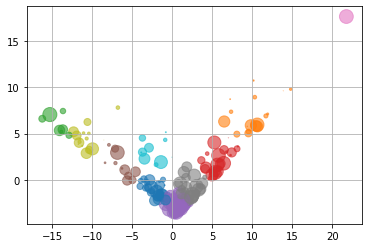

In [39]:
import pandas as pd
user_info=pd.read_csv('user_info.csv')
def getUserAbilityOnCase(userId,caseId):
    """
    获取学生在某道题目上的表现,综合各种因素
    :param userId:
    :param caseId:
    :return:
    finished
    """
    if not caseId in getCaseIdsShouldDoByUserId(userId): # 不需要做
        return -2
    if not caseId in userFinishCaseIds[userId]: # 需要做而没有做
        return -1
    return (getScoreByUserIdAndCaseId(userId,caseId)*(3+difficult_degree(caseId))-44.47508515412085)/(3131.785960466791-44.47508515412085)+1
def getUserAbilityOnType(userId,typeId):
    """
    在某一类型的题目上的综合表现 利用 getUserAbilityOnCase
    :param userId:
    :param typeId:
    :return:
    finished
    """
    s=0
    for i in set(userFinishCaseIds[userId])&set(getCaseIdsShouldDoByUserId(userId))&set(caseIdsByType[typeId]):
        s+=getUserAbilityOnCase(userId,i)
    if s==0:
        return 0
    # return s
    return s/len(set(userFinishCaseIds[userId])&set(getCaseIdsShouldDoByUserId(userId))&set(caseIdsByType[typeId]))*float(user_info[user_info['id']==userId]['finishRateOfType'+str(typeId)])*100/1.3536934220462282
def getUserAbility(userId):
    """
    综合编程能力评估函数 利用 getUserAbilityOnCase
    :param userId:
    :return:
    finished
    """
    s=0
    for i in range(8):
        s+=getUserAbilityOnType(userId,i)
    return s/8
user_info['userAbility']=[getUserAbility(i) for i in validUserIds]
for i in range(8):
    user_info['userAbilityOfType'+str(i)]=[getUserAbilityOnType(j,i) for j in validUserIds]
user_info.to_csv('user_info.csv',index=None)

def getLikeDegreeByUserAndType(userId,typeId):
    """
    返回学生对某类题目的喜欢程度 结合uploadNum avgScore
    :param userId:
    :param typeId:
    :return:
    finished
    """
    import math
    user_info=pd.read_csv('user_info.csv')
    return 10*math.sqrt(10*math.sqrt(float(user_info[user_info['id']==userId]['uploadSumOfType'+str(typeId)])*float(user_info[user_info['id']==userId]['avgScoreOfType'+str(typeId)])/528))

for i in range(8):
    user_info['likeDegreeOfType'+str(i)]=[getLikeDegreeByUserAndType(j,i) for j in validUserIds]

def delay_degree_of_user(userId):
    user_info=pd.read_csv('user_info.csv')
    import math
    return 10*math.sqrt(10*math.sqrt(float(user_info[user_info['id']==userId]['avgTimeSpan'])/57.010083756345175))
user_info['delayDegree']=np.array([delay_degree_of_user(i) for i in validUserIds])
user_info.to_csv('user_info.csv',index=None)

def getCodeRoadForUser(userId):
    user_info=pd.read_csv('user_info.csv')
    abilities=[]
    for i in range(8):
        abilities.append(float(user_info[user_info['id']==userId]['userAbilityOfType'+str(i)]))
    abilities=np.array(abilities)
    return list(np.argsort(abilities))

user_before_pca=pd.read_csv('user_info.csv')
user_before_pca['uploadSum']=StandardScaler().fit_transform(np.array(user_before_pca['uploadSum']).reshape(-1,1))
columns_to_drop=[str(i)+'to'+str(i+1) for i in range(24)]
columns_to_drop.append('timeType')
columns_to_drop.append('dayRate')
columns_to_drop.append('afternoonRate')
columns_to_drop.append('nightRate')
columns_to_drop.append('deepRate')
user_before_pca['caseNumFinish']=StandardScaler().fit_transform(np.array(user_before_pca['caseNumFinish']).reshape(-1,1))
columns_to_drop.append('avgUploadNum')
columns_to_drop.append('avgScore')
columns_to_drop.append('avgScoreIgnoreUndo')
user_before_pca['avgTimeSpan']=StandardScaler().fit_transform(np.array(user_before_pca['avgTimeSpan']).reshape(-1,1))
for i in range(8):
    user_before_pca['likeDegreeOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['likeDegreeOfType'+str(i)]).reshape(-1,1))
    user_before_pca['userAbilityOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['userAbilityOfType'+str(i)]).reshape(-1,1))
    user_before_pca['uploadSumOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['uploadSumOfType'+str(i)]).reshape(-1,1))
    user_before_pca['avgUploadNumOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['avgUploadNumOfType'+str(i)]).reshape(-1,1))
    user_before_pca['avgUploadNumIgnoreUndoOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['avgUploadNumIgnoreUndoOfType'+str(i)]).reshape(-1,1))
    user_before_pca['avgScoreOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['avgScoreOfType'+str(i)]).reshape(-1,1))
    user_before_pca['avgScoreIgnoreUndoOfType'+str(i)]=StandardScaler().fit_transform(np.array(user_before_pca['avgScoreIgnoreUndoOfType'+str(i)]).reshape(-1,1))
user_before_pca['userAbility']=StandardScaler().fit_transform(np.array(user_before_pca['userAbility']).reshape(-1,1))
user_before_pca['delayDegree']=StandardScaler().fit_transform(np.array(user_before_pca['delayDegree']).reshape(-1,1))
user_before_pca=user_before_pca.drop(columns=columns_to_drop)
user_before_pca.to_csv('user_before_pca.csv',index=None)

user_before_pca=pd.read_csv('user_before_pca.csv')
user_before_pca_array=user_before_pca.iloc[:,1:].values
user_pca_model=PCA(n_components=2).fit(user_before_pca_array)
user_pca_2_dim=user_pca_model.transform(user_before_pca_array)
with open('user_pca_2_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    cw.writerow(['id','dim0','dim1'])
    for i in range(254):
        cw.writerow([validUserIds[i],user_pca_2_dim[i,0],user_pca_2_dim[i,1]])
user_reconstructed=user_pca_model.inverse_transform(user_pca_2_dim)
user_pca_loss=np.mean(np.square(user_reconstructed-user_before_pca_array))
print('PCA loss:'+str(user_pca_loss))

user_pca_2_dim=pd.read_csv('user_pca_2_dim.csv')
user_kmeans=KMeans(n_clusters=10,max_iter=2000).fit(user_pca_2_dim.iloc[:,1:].values)
color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:cyan','tab:olive']
labels=pd.DataFrame({'label':user_kmeans.labels_})
data=pd.DataFrame(user_pca_2_dim.iloc[:,1:].values,columns=['x','y'])
data=pd.concat([data,labels],axis=1)
color=[color_list[i] for i in data['label']]
size=np.pi * (8 * np.random.rand(882))**2
fig, ax = plt.subplots()
ax.scatter(data['x'],data['y'],c=color,s=size,alpha=0.6)
ax.grid(True)
plt.show()


In [2]:
ctGroupUserIds

[0, 1, 7, 12, 14, 15, 17, 28, 34, 53, 56, 139, 159, 172, 228, 254, 259]

[1, 2, 3, 2, 3, 2]

In [55]:
def getCodeTimeSimilarityOfTwoUser(userId1,userId2):
    """
    返回两个学生的编程时间分布的相似度 值越大,越相似 用于寻找编程搭档(寻找编程时间和自己最贴近的同学)的一个角度
    :param userId1:
    :param userId2:
    :return:
    finished
    """
    def kl_divergence(p,q):
        return np.sum(p*np.log(p/q))
    def js_divergence(p,q):
        return (kl_divergence(p,(p+q)/2)+kl_divergence(q,(p+q)/2))/2
    user_info=pd.read_csv('user_info.csv')
    timeRates1=np.array([float(user_info[user_info['id']==userId1][str(i)+'to'+str(i+1)+'rate']) for i in range(24)])
    timeRates2=np.array([float(user_info[user_info['id']==userId2][str(i)+'to'+str(i+1)+'rate']) for i in range(24)])
    return 1-js_divergence(timeRates1+0.01,timeRates2+0.01)
def getPartnersByTime(userId):
    timeSimilaritys=list(np.argsort(np.array([-getCodeTimeSimilarityOfTwoUser(userId,i) for i in validUserIds])))
    return [validUserIds[i] for i in timeSimilaritys]

def getCodeScoreSimilarityOfTwoUser(userId1,userId2):
    """
    返回两个学生在8种类型的题目上的得分的相似度 相似度越高,越相似 用于寻找编程搭档的一个角度
    :param userId1:t
    :param userId2:
    :return:
    finished
    """
    user_info=pd.read_csv('user_info.csv')
    scores1=np.array([float(user_info[user_info['id']==userId1]['avgScoreIgnoreUndoOfType'+str(i)]) for i in range(8)])
    scores2=np.array([float(user_info[user_info['id']==userId2]['avgScoreIgnoreUndoOfType'+str(i)]) for i in range(8)])
    return 100-np.sqrt(np.mean(np.square(scores1-scores2)))
def getPartnersByScoreClose(userId):
    scoreSimilaritys=list(np.argsort(np.array([-getCodeScoreSimilarityOfTwoUser(userId,i) for i in validUserIds])))
    return [validUserIds[i] for i in scoreSimilaritys]
def getPartnersByScoreFar(userId):
    return getPartnersByScoreClose(userId)[::-1]

def getCodeAbilitySimilarityOfTwoUser(userId1,userId2):
    """
    综合各种因素,返回两个学生编程能力的相似度 用于"一键寻找"最佳编程搭档 需要降维、聚类
    :param userId1:
    :param userId2:
    :return:
    """
    user_pca_2_dim=pd.read_csv('user_pca_2_dim.csv')
    return -np.sqrt(np.mean(np.square(user_pca_2_dim[user_pca_2_dim['id']==userId1].iloc[:,1:].values-user_pca_2_dim[user_pca_2_dim['id']==userId2].iloc[:,1:].values)))
def getPartnersByAbility(userId):
    abilitySimilaritys=list(np.argsort(np.array([-getCodeAbilitySimilarityOfTwoUser(userId,i) for i in validUserIds])))
    return [validUserIds[i] for i in abilitySimilaritys]

In [44]:
def getRecommendCaseIdsUserLike(userId):
    user_info=pd.read_csv('user_info.csv')
    typeIds=[]
    typeIds1=list(np.argsort(-np.array([float(user_info[user_info['id']==userId]['userAbilityOfType'+str(i)]) for i in range(8)]))[:4])
    typeIds2=list(np.argsort(np.array([float(user_info[user_info['id']==userId]['likeDegreeOfType'+str(i)]) for i in range(8)]))[:4])
    for i in range(4):
        for j in range(i+1):
            typeIds.append(typeIds1[i])
            typeIds.append(typeIds2[i])
    recommendCaseIds=set()
    for i in range(25):
        recommendCaseIds.add(random.choice(caseIdsByType[random.choice(typeIds)]))
    return list(recommendCaseIds)

def getRecommendCaseIdsUserDislike(userId):
    user_info=pd.read_csv('user_info.csv')
    typeIds=[]
    typeIds1=np.argsort(np.array([float(user_info[user_info['id']==userId]['userAbilityOfType'+str(i)]) for i in range(8)]))[:4]
    typeIds2=np.argsort(-np.array([float(user_info[user_info['id']==userId]['likeDegreeOfType'+str(i)]) for i in range(8)]))[:4]
    for i in range(4):
        for j in range(i+1):
            typeIds.append(typeIds1[i])
            typeIds.append(typeIds2[i])
    recommendCaseIds=set()
    for i in range(25):
        recommendCaseIds.add(random.choice(caseIdsByType[random.choice(typeIds)]))
    return list(recommendCaseIds)

In [ ]:
# def self_analysis_report(userId):
#     """
#     此方法生成一个个人编程分析报告,需要尽可能利用包含在`test_data.json`中的所有关于这个学生的信息
#     包括但不限于:
#         1. 画出编程时间分布图 两个24列的条形图 一个表示具体的提交次数,另一个表示具体的提交比例 画出在四个时间段(上午、下午、晚上、深夜)的提交次数的分布(饼图) 并显示编程的时间习惯 `timeType`为0表示"上午型",即习惯于在上午编程 1表示"下午型" 2表示"晚上型" 3表示"深夜型" 可作为"编程习惯分析"的一部分
#         2. 给出和这位同学编程时间分布最接近的5位同学的编号
#         3. 画出8种类型的题目的平均得分(忽略没做、不忽略没做) 条形图
#         4. 画出这位学生最倾向于(最喜欢)做的题目 由高到低排序 条形图 8列
#         5. 给出这位学生的"拖延症指数" 用`avgTimeSpan`评估
#         6. 画出8种类型的题目的完成率 条形图
#         7.
#     :param userId:
#     :return:
#     """
#     user_info=pd.read_csv('user_info.csv')
#     return 0
# def all_users_analysis_report():
#     """
#     基于全体学生的数据生成分析报告
#     :return:
#     """
#     user_info=pd.read_csv('user_info.csv')
#     return 0

In [18]:
################################################################################################################################

# 题目视角的分析

# PCA 降维到4维

In [44]:
# new_dim=2
new_dim=4
# cases_data_pca=PCA(n_components=new_dim).fit_transform(cases_result_array)
model_pca=PCA(n_components=new_dim).fit(cases_result_array)
cases_data_pca=model_pca.transform(cases_result_array)
cases_reconstructed=model_pca.inverse_transform(cases_data_pca)
with open('cases_pca_4_dim_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1','dim2','dim3']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_data_pca[i,0],cases_data_pca[i,1],cases_data_pca[i,2],cases_data_pca[i,3]])
pca_loss=np.mean(np.square(cases_result_array-cases_reconstructed))
print('PCA 4 dim mean square loss:{}'.format(pca_loss))

PCA 4 dim mean square loss:0.13871950667820518


# PCA 降维到2维

In [45]:
new_dim=2
# new_dim=4
# cases_data_pca=PCA(n_components=new_dim).fit_transform(cases_result_array)
model_pca=PCA(n_components=new_dim).fit(cases_result_array)
cases_data_pca=model_pca.transform(cases_result_array)
cases_reconstructed=model_pca.inverse_transform(cases_data_pca)
with open('cases_pca_2_dim_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_data_pca[i,0],cases_data_pca[i,1]])
pca_loss=np.mean(np.square(cases_result_array-cases_reconstructed))
print('PCA 2 dim mean square loss:{}'.format(pca_loss))

PCA 2 dim mean square loss:0.2976193041640051


# 把数据转成Tensor格式

In [46]:
batch_size=32
cases_tensor=torch.tensor(cases_result_array,dtype=torch.float)
cases_dataset=TensorDataset(cases_tensor)
cases_sampler=RandomSampler(cases_dataset)
cases_dataloader=DataLoader(cases_dataset,sampler=cases_sampler,batch_size=batch_size)


# AE & VAE 降维到2维
## AE & VAE 模型定义

In [47]:
dim=cases_result_array.shape[1]
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(dim,20),
            nn.ReLU(True),
            nn.Linear(20,16),
            nn.ReLU(True),
            nn.Linear(16,8),
            nn.ReLU(True),
            nn.Linear(8,4),
            nn.ReLU(True),
            nn.Linear(4,2)
        )
        self.decoder=nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(True),
            nn.Linear(4,8),
            nn.ReLU(True),
            nn.Linear(8,16),
            nn.ReLU(True),
            nn.Linear(16,20),
            nn.ReLU(True),
            nn.Linear(20,dim)
        )
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1=nn.Linear(dim,16)
        self.fc21=nn.Linear(16,2)
        self.fc22=nn.Linear(16,2)
        self.fc3=nn.Linear(2,16)
        self.fc4=nn.Linear(16,dim)
    def encoder(self,x):
        h1=F.relu(self.fc1(x))
        return self.fc21(h1),self.fc22(h1)
    def reparametrize(self,mu,logvar):
        std=logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps=torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps=torch.FloatTensor(std.size()).normal_()
        eps=Variable(eps)
        return eps.mul(std).add_(mu)
    def decode(self,z):
        h3=F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    def forward(self,x):
        mu,logvar=self.encoder(x)
        z=self.reparametrize(mu,logvar)
        return self.decode(z),mu,logvar
def loss_vae(recon_x,x,mu,logvar,criterion):
    """
    recon_x: generating values
    x: origin values
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD
model_classes={'AE':AE(),'VAE':VAE()}
learning_rate=1e-3
num_epochs=2000
# num_epochs=0 # 已经训练好了

## Train AE

In [48]:
model_type='AE'
# model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_2_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_AE_2_dim.pt')
cases_ae_encoder=final_model.encoder(cases_tensor.cuda()).detach().cpu().numpy()
with open('cases_ae_encode_2_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_ae_encoder[i,0],cases_ae_encoder[i,1]])


C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch [1/2000],loss:5375.42919921875
epoch [100/2000],loss:1.5279216766357422
epoch [200/2000],loss:0.8029865026473999
epoch [300/2000],loss:0.7911138534545898
epoch [400/2000],loss:0.6096683144569397
epoch [500/2000],loss:0.7754116654396057
epoch [600/2000],loss:0.817295491695404
epoch [700/2000],loss:1.1490877866744995
epoch [800/2000],loss:0.6539499759674072
epoch [900/2000],loss:1.1336991786956787
epoch [1000/2000],loss:0.6970823407173157
epoch [1100/2000],loss:0.6419059634208679
epoch [1200/2000],loss:0.5764960050582886
epoch [1300/2000],loss:0.3725663721561432
epoch [1400/2000],loss:0.384949266910553
epoch [1500/2000],loss:0.3952477276325226
epoch [1600/2000],loss:0.5831933617591858
epoch [1700/2000],loss:0.18598684668540955
epoch [1800/2000],loss:0.37410634756088257
epoch [1900/2000],loss:0.18918655812740326
epoch [2000/2000],loss:0.36269959807395935
Best AE model' loss:0.13609889149665833


## Train VAE


In [49]:
# model_type='AE'
model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_2_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_VAE_2_dim.pt')
cases_vae_encoder=final_model.encoder(cases_tensor.cuda())[0].detach().cpu().numpy()
with open('cases_vae_encode_2_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_vae_encoder[i,0],cases_vae_encoder[i,1]])


C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch [1/2000],loss:10342.6064453125
epoch [100/2000],loss:10556.076171875
epoch [200/2000],loss:11199.6845703125
epoch [300/2000],loss:12288.248046875
epoch [400/2000],loss:8786.1923828125
epoch [500/2000],loss:10055.162109375
epoch [600/2000],loss:10264.267578125
epoch [700/2000],loss:7826.16064453125
epoch [800/2000],loss:14685.962890625
epoch [900/2000],loss:10959.8271484375
epoch [1000/2000],loss:12995.03515625
epoch [1100/2000],loss:10529.208984375
epoch [1200/2000],loss:10101.2119140625
epoch [1300/2000],loss:7112.88623046875
epoch [1400/2000],loss:9829.373046875
epoch [1500/2000],loss:9509.7490234375
epoch [1600/2000],loss:11904.224609375
epoch [1700/2000],loss:10005.5556640625
epoch [1800/2000],loss:8809.65625
epoch [1900/2000],loss:12563.28515625
epoch [2000/2000],loss:9548.66796875
Best VAE model' loss:4468.6591796875


# AE & VAE 降维到4维
## AE & VAE 模型定义

In [50]:
dim=cases_result_array.shape[1]
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(dim,20),
            nn.ReLU(True),
            nn.Linear(20,16),
            nn.ReLU(True),
            nn.Linear(16,8),
            nn.ReLU(True),
            nn.Linear(8,4)
        )
        self.decoder=nn.Sequential(
            nn.Linear(4,8),
            nn.ReLU(True),
            nn.Linear(8,16),
            nn.ReLU(True),
            nn.Linear(16,20),
            nn.ReLU(True),
            nn.Linear(20,dim)
        )
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1=nn.Linear(dim,16)
        self.fc21=nn.Linear(16,4)
        self.fc22=nn.Linear(16,4)
        self.fc3=nn.Linear(4,16)
        self.fc4=nn.Linear(16,dim)
    def encoder(self,x):
        h1=F.relu(self.fc1(x))
        return self.fc21(h1),self.fc22(h1)
    def reparametrize(self,mu,logvar):
        std=logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps=torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps=torch.FloatTensor(std.size()).normal_()
        eps=Variable(eps)
        return eps.mul(std).add_(mu)
    def decode(self,z):
        h3=F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    def forward(self,x):
        mu,logvar=self.encoder(x)
        z=self.reparametrize(mu,logvar)
        return self.decode(z),mu,logvar
def loss_vae(recon_x,x,mu,logvar,criterion):
    """
    recon_x: generating values
    x: origin values
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD
model_classes={'AE':AE(),'VAE':VAE()}
learning_rate=1e-3
num_epochs=2000
# num_epochs=0 # 已经训练好了


## Train AE

In [51]:
model_type='AE'
# model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_4_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_AE_4_dim.pt')
cases_ae_encoder=final_model.encoder(cases_tensor.cuda()).detach().cpu().numpy()
with open('cases_ae_encode_4_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1','dim2','dim3']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_ae_encoder[i,0],cases_ae_encoder[i,1],cases_ae_encoder[i,2],cases_ae_encoder[i,3]])



epoch [1/2000],loss:7487.82958984375
epoch [100/2000],loss:0.3725070357322693
epoch [200/2000],loss:0.9923311471939087
epoch [300/2000],loss:0.35196101665496826
epoch [400/2000],loss:0.29708805680274963
epoch [500/2000],loss:0.4278900623321533
epoch [600/2000],loss:0.27035120129585266
epoch [700/2000],loss:1.2398667335510254
epoch [800/2000],loss:0.36756402254104614
epoch [900/2000],loss:0.394062876701355
epoch [1000/2000],loss:0.7929007411003113
epoch [1100/2000],loss:0.29412582516670227
epoch [1200/2000],loss:0.2850358784198761
epoch [1300/2000],loss:0.2269110232591629
epoch [1400/2000],loss:0.2951788306236267
epoch [1500/2000],loss:0.44792744517326355
epoch [1600/2000],loss:0.41643226146698
epoch [1700/2000],loss:0.2579497992992401
epoch [1800/2000],loss:0.3996681869029999
epoch [1900/2000],loss:0.22203929722309113
epoch [2000/2000],loss:0.36679112911224365
Best AE model' loss:0.12725231051445007


## Train VAE

In [52]:

# model_type='AE'
model_type='VAE'
model=model_classes[model_type].cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)
best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    for data in cases_dataloader:
        batch_cases=data[0].cuda()
        output=model(batch_cases)
        if model_type=='VAE':
            loss=loss_vae(output[0],batch_cases,output[1],output[2],criterion)
        else:
            loss=criterion(output,batch_cases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss.item()<best_loss:
            best_loss=loss.item()
            torch.save(model,'best_model_{}_4_dim.pt'.format(model_type))
    # if (epoch+1)%50==0:
    # print('epoch [{}/{}],loss:{:.4f}'.format(epoch+1,num_epochs,loss.item()))
    if (epoch+1)%100==0 or epoch==0:
        print('epoch ['+str(epoch+1)+'/'+str(num_epochs)+'],loss:'+str(loss.item()))
print('Best '+model_type+' model\' loss:'+str(best_loss))
final_model=torch.load('best_model_VAE_4_dim.pt')
cases_vae_encoder=final_model.encoder(cases_tensor.cuda())[0].detach().cpu().numpy()
with open('cases_vae_encode_4_dim.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','dim0','dim1','dim2','dim3']
    cw.writerow(header)
    for i in range(882):
        cw.writerow([i,cases_vae_encoder[i,0],cases_vae_encoder[i,1],cases_vae_encoder[i,2],cases_vae_encoder[i,3]])


epoch [1/2000],loss:3.929740457017344e+17
epoch [100/2000],loss:4294169329664.0
epoch [200/2000],loss:8291140239360.0
epoch [300/2000],loss:985208512.0
epoch [400/2000],loss:7973082624.0
epoch [500/2000],loss:2068561408.0
epoch [600/2000],loss:140760400.0
epoch [700/2000],loss:165399008.0
epoch [800/2000],loss:14278.1826171875
epoch [900/2000],loss:8752.7763671875
epoch [1000/2000],loss:5993.62255859375
epoch [1100/2000],loss:9238.2451171875
epoch [1200/2000],loss:10521.5263671875
epoch [1300/2000],loss:7309.04638671875
epoch [1400/2000],loss:13592.1494140625
epoch [1500/2000],loss:12815.015625
epoch [1600/2000],loss:10724.505859375
epoch [1700/2000],loss:11835.3056640625
epoch [1800/2000],loss:12683.2685546875
epoch [1900/2000],loss:8651.755859375
epoch [2000/2000],loss:7287.6142578125
Best VAE model' loss:3780.02880859375


# 降维处理已结束,下面是基于学生答题表现的聚类分析

In [2]:
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_final=pd.read_csv('cases_analysis_final.csv').iloc[:,1:]

cases_pca_2_dim=pd.read_csv('cases_pca_2_dim_result.csv')
cases_pca_4_dim=pd.read_csv('cases_pca_4_dim_result.csv')
cases_ae_2_dim=pd.read_csv('cases_ae_encode_2_dim.csv')
cases_ae_4_dim=pd.read_csv('cases_ae_encode_4_dim.csv')
cases_vae_2_dim=pd.read_csv('cases_vae_encode_2_dim.csv')
cases_vae_4_dim=pd.read_csv('cases_vae_encode_4_dim.csv')

cases_analysis_final['difficultDegree']=StandardScaler().fit_transform(np.array(cases_analysis_final['difficultDegree']).reshape(-1,1))

cases_pca_2_dim['dim0']=StandardScaler().fit_transform(np.array(cases_pca_2_dim['dim0']).reshape(-1,1))
cases_pca_2_dim['dim1']=StandardScaler().fit_transform(np.array(cases_pca_2_dim['dim1']).reshape(-1,1))

cases_ae_2_dim['dim0']=StandardScaler().fit_transform(np.array(cases_ae_2_dim['dim0']).reshape(-1,1))
cases_ae_2_dim['dim1']=StandardScaler().fit_transform(np.array(cases_ae_2_dim['dim1']).reshape(-1,1))

cases_ae_4_dim['dim0']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim0']).reshape(-1,1))
cases_ae_4_dim['dim1']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim1']).reshape(-1,1))
cases_ae_4_dim['dim2']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim2']).reshape(-1,1))
cases_ae_4_dim['dim3']=StandardScaler().fit_transform(np.array(cases_ae_4_dim['dim3']).reshape(-1,1))

cases_vae_2_dim['dim0']=StandardScaler().fit_transform(np.array(cases_vae_2_dim['dim0']).reshape(-1,1))
cases_vae_2_dim['dim1']=StandardScaler().fit_transform(np.array(cases_vae_2_dim['dim1']).reshape(-1,1))

cases_vae_4_dim['dim0']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim0']).reshape(-1,1))
cases_vae_4_dim['dim1']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim1']).reshape(-1,1))
cases_vae_4_dim['dim2']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim2']).reshape(-1,1))
cases_vae_4_dim['dim3']=StandardScaler().fit_transform(np.array(cases_vae_4_dim['dim3']).reshape(-1,1))

km_pca_2_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_pca_2_dim.iloc[:,1:].values)
km_pca_4_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_pca_4_dim.iloc[:,1:].values)
km_ae_2_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_ae_2_dim.iloc[:,1:].values)
km_ae_4_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_ae_4_dim.iloc[:,1:].values)
km_vae_2_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_vae_2_dim.iloc[:,1:].values)
km_vae_4_dim=KMeans(n_clusters=8,max_iter=2000).fit(cases_vae_4_dim.iloc[:,1:].values)
km_raw=KMeans(n_clusters=8,max_iter=2000).fit(cases_analysis_final)

mark=['or','ob','og','ok','^r','+r','sr','dr','<r','pr']

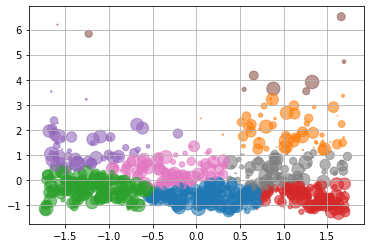

In [3]:
# data=cases_pca_2_dim.iloc[:,1:].values
# j=0
# for i in km_pca_2_dim.labels_:
#     plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
#     j+=1
# plt.show()

color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:cyan','tab:olive']
labels=pd.DataFrame({'label':km_pca_2_dim.labels_})
data=pd.DataFrame(cases_pca_2_dim.iloc[:,1:].values,columns=['x','y'])
data=pd.concat([data,labels],axis=1)
color=[color_list[i] for i in data['label']]
size=np.pi * (8 * np.random.rand(882))**2
fig, ax = plt.subplots()
ax.scatter(data['x'],data['y'],c=color,s=size,alpha=0.6)
ax.grid(True)
plt.show()


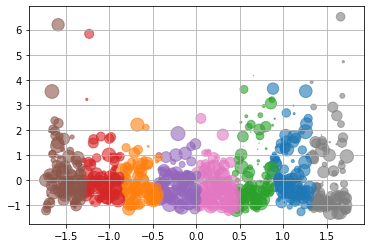

In [4]:
# data=cases_pca_2_dim.iloc[:,1:].values
# j=0
# for i in km_raw.labels_:
#     plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
#     j+=1
# plt.show()

color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:cyan','tab:olive']
labels=pd.DataFrame({'label':km_raw.labels_})
data=pd.DataFrame(cases_pca_2_dim.iloc[:,1:].values,columns=['x','y'])
data=pd.concat([data,labels],axis=1)
color=[color_list[i] for i in data['label']]
size=np.pi * (8 * np.random.rand(882))**2
fig, ax = plt.subplots()
ax.scatter(data['x'],data['y'],c=color,s=size,alpha=0.6)
ax.grid(True)
plt.show()

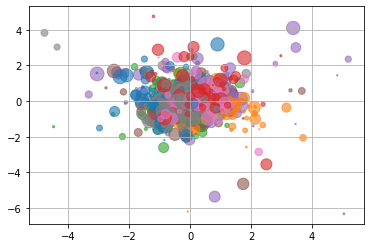

In [5]:
# data=cases_vae_2_dim.iloc[:,1:].values
# j=0
# for i in km_vae_4_dim.labels_:
#     plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
#     j+=1
# plt.show()

color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:cyan','tab:olive']
labels=pd.DataFrame({'label':km_vae_4_dim.labels_})
data=pd.DataFrame(cases_vae_2_dim.iloc[:,1:].values,columns=['x','y'])
data=pd.concat([data,labels],axis=1)
color=[color_list[i] for i in data['label']]
size=np.pi * (8 * np.random.rand(882))**2
fig, ax = plt.subplots()
ax.scatter(data['x'],data['y'],c=color,s=size,alpha=0.6)
ax.grid(True)
plt.show()

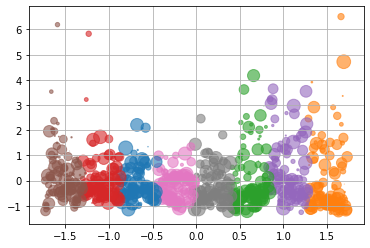

In [6]:
# data=cases_pca_2_dim.iloc[:,1:].values
# j=0
# for i in km_pca_4_dim.labels_:
#     plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
#     j+=1
# plt.show()

color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:cyan','tab:olive']
labels=pd.DataFrame({'label':km_pca_4_dim.labels_})
data=pd.DataFrame(cases_pca_2_dim.iloc[:,1:].values,columns=['x','y'])
data=pd.concat([data,labels],axis=1)
color=[color_list[i] for i in data['label']]
size=np.pi * (8 * np.random.rand(882))**2
fig, ax = plt.subplots()
ax.scatter(data['x'],data['y'],c=color,s=size,alpha=0.6)
ax.grid(True)
plt.show()


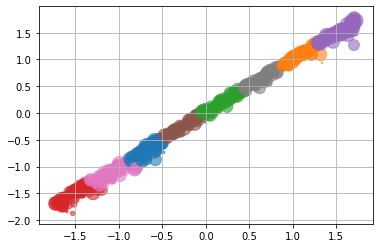

In [7]:
# data=cases_ae_2_dim.iloc[:,1:].values
# j=0
# for i in km_ae_2_dim.labels_:
#     plt.plot([data[j:j+1,0]], [data[j:j+1,1]], mark[i], markersize = 5)
#     j+=1
# plt.show()

color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:cyan','tab:olive']
labels=pd.DataFrame({'label':km_ae_2_dim.labels_})
data=pd.DataFrame(cases_ae_2_dim.iloc[:,1:].values,columns=['x','y'])
data=pd.concat([data,labels],axis=1)
color=[color_list[i] for i in data['label']]
size=np.pi * (8 * np.random.rand(882))**2
fig, ax = plt.subplots()
ax.scatter(data['x'],data['y'],c=color,s=size,alpha=0.6)
ax.grid(True)
plt.show()


# 题目视角部分的数据可视化

In [23]:
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import csv
import pandas as pd
import time
import datetime
import os
import urllib.request,urllib.parse
import zipfile
import win32api
import matplotlib.pyplot as mp
import seaborn as sns
import random
mp.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mp.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
root_path=os.path.abspath('.')
test_data_path='test_data.json'
# test_data_path='E:\\0学习资料\\A软件工程\\数据科学大作业\\workspace\\test_data.json'
test_data=json.loads(open(test_data_path,encoding='utf-8').read())
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
userIds=[str(i) for i in sorted([int(i) for i in list(test_data.keys())])]
updateUserIds={}
getOldUserId=[]
for i in range(len(userIds)):
    updateUserIds.update({userIds[i]:i})
    getOldUserId.append(userIds[i])
del userIds
case_ids=set()
for i in test_data:
    for j in test_data[i]['cases']:
        case_ids.add(j['case_id'])
case_ids=sorted(list(case_ids))
updateCaseIds={}
getOldCaseId=[]
for i in range(len(case_ids)):
    updateCaseIds.update({case_ids[i]:i})
    getOldCaseId.append(case_ids)
del case_ids
new_data=[]
for i in range(271):
    new_data.append(test_data[getOldUserId[i]]['cases'])
del test_data
for i in range(271):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_id']=updateCaseIds[new_data[i][j]['case_id']]
userFinishCaseIds=[]
for i in range(271):
    tempList=[]
    for j in range(len(new_data[i])):
        tempList.append(new_data[i][j]['case_id'])
    userFinishCaseIds.append(sorted(tempList))
caseIds200=[]
groupCaseIds=[]
ids882=[i for i in range(882)]
theFifthGroupCaseIds=set()
for i in range(271):
    ids='.'.join([str(i) for i in userFinishCaseIds[i]])
    if len(userFinishCaseIds[i])==200 and ids not in caseIds200:
        caseIds200.append(ids)
        groupCaseIds.append(userFinishCaseIds[i])
        for j in userFinishCaseIds[i]:
            ids882[j]=-1
for i in ids882:
    if i!=-1:
        theFifthGroupCaseIds.add(i)
fifthGroupIds=list(theFifthGroupCaseIds)
for i in range(271):
    if 190<=len(userFinishCaseIds[i])<=200:
        flag=False
        for j in theFifthGroupCaseIds:
            if j in userFinishCaseIds[i]:
                flag=True
                break
        if flag:
            for j in userFinishCaseIds[i]:
                fifthGroupIds.append(j)
groupCaseIds.append(sorted(list(set(fifthGroupIds))))
del fifthGroupIds
del theFifthGroupCaseIds
del ids882
del caseIds200
groupUserIds=[[] for i in range(5)]
ctGroupUserIds=[]
validUserIds=[]
for i in range(271):
    if len(userFinishCaseIds[i])>200:
        groupUserIds[4].append(i)
        continue
    if len(userFinishCaseIds[i])<=10:
        ctGroupUserIds.append(i)
        continue
    if i==261:
        groupUserIds[3].append(i)
        continue
    g=[]
    for j in range(5):
        flag=True
        for k in userFinishCaseIds[i]:
            if not k in groupCaseIds[j]:
                flag=False
                break
        if flag:
            g.append(j)
    if len(g)==1:
        groupUserIds[g[0]].append(i)
    else:
        ctGroupUserIds.append(i)
for i in groupUserIds:
    for j in i:
        validUserIds.append(j)
validUserIds=sorted(validUserIds)
groupUserNum=[len(i) for i in groupUserIds]
caseGroups=[[] for i in range(882)]
caseUserNum=[0 for i in range(882)]
caseUserNumInFact=[0 for i in range(882)]
caseScoreIgnoreUndo=[0 for i in range(882)]
caseScoreCountUndo=[0 for i in range(882)]
caseIdsByType=[set() for i in range(8)]
for i in range(882):
    for j in userFinishCaseIds:
        if i in j:
            caseUserNumInFact[i]+=1
    for j in range(len(groupCaseIds)):
        if i in groupCaseIds[j]:
            caseGroups[i].append(j)
            caseUserNum[i]+=groupUserNum[j]
caseFinishRate=list(np.array(caseUserNumInFact)/np.array(caseUserNum))
for i in range(len(new_data)):
    if i not in validUserIds:
        continue
    for j in range(len(new_data[i])):
        caseScoreIgnoreUndo[new_data[i][j]['case_id']]+=new_data[i][j]['final_score']
caseScoreCountUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNum))
caseScoreIgnoreUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNumInFact))
for i in range(len(new_data)):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_type']=type_dict[new_data[i][j]['case_type']]
        caseIdsByType[new_data[i][j]['case_type']].add(new_data[i][j]['case_id'])
for i in range(len(caseIdsByType)):
    caseIdsByType[i]=sorted(list(caseIdsByType[i]))
def getGroupIdByUserId(userId):
    for i in range(len(groupUserIds)):
        if userId in groupUserIds[i]:
            return i
    return -1
def getGroupIdsByCaseId(caseId):
    gs=[]
    for i in range(len(groupCaseIds)):
        if caseId in groupCaseIds[i]:
            gs.append(i)
    return gs
def getTypesByCaseId(caseId):
    ts=[]
    for i in range(len(caseIdsByType)):
        if caseId in caseIdsByType[i]:
            ts.append(i)
    return ts
def getScoreByUserIdAndCaseId(userId,caseId):
    """
    返回某个用户在某道题上的得分,如果用户应该做这道题而没有做,则返回0分,如果这道题这个用户本来就不需要做(即用户所在的group内不包含这道题),就返回-1
    :param userId:
    :param caseId:
    :return:
    """
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['final_score']
    return 0
def getCaseIdsByGroupAndType(groupId,typeId):
    return sorted(list(set(caseIdsByType[typeId])&set(groupCaseIds[groupId])))
def getUploadNumByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return len(i['upload_records'])
    return 0
def getFinalUploadCodeUrlByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return ''
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['code_url']
    return ''
def getUploadSumByCaseId(caseId):
    r=0
    for i in validUserIds:
        r+=(getUploadNumByUserAndCase(i,caseId) if getUploadNumByUserAndCase(i,caseId)>0 else 0)
    return r
def getTimeSpanByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['upload_time']-i['upload_records'][0]['upload_time']
    return -1
def getAvgTimeSpanByCase(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCase(i,caseId)>-1:
            r+=getTimeSpanByUserAndCase(i,caseId)
            n+=1
    return r/n
typeOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(8)]).transform([[i] for i in range(8)]).toarray()
groupOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(5)]).transform([[i] for i in range(5)]).toarray()
cases_analysis_result=np.array([])
def time_diff_minute(firstTime,secondTime):
    return (datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(secondTime/1000)),"%Y-%m-%d %H:%M:%S")-datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(firstTime/1000)),"%Y-%m-%d %H:%M:%S")).total_seconds()/60
def getTimeSpanByUserAndCaseInMinute(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return time_diff_minute(i['upload_records'][0]['upload_time'],i['upload_records'][-1]['upload_time'])
    return -1
def getAvgTimeSpanByCaseInMinute(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCaseInMinute(i,caseId)>-1:
            r+=getTimeSpanByUserAndCaseInMinute(i,caseId)
            n+=1
    return r/n
for i in range(882):
    typeId=np.zeros((8,))
    for j in getTypesByCaseId(i):
        typeId+=np.array(typeOneHot[j])
    finishRate=caseFinishRate[i]
    userNum=caseUserNum[i]
    userNumInFact=caseUserNumInFact[i]
    scoreIgnoreUndo=caseScoreIgnoreUndo[i]
    scoreCountUndo=caseScoreCountUndo[i]
    groupId=np.zeros((5,))
    for j in getGroupIdsByCaseId(i):
        groupId+=np.array(groupOneHot[j])
    uploadSum=getUploadSumByCaseId(i)
    uploadAvg=uploadSum/userNum
    uploadAvgInFact=uploadSum/userNumInFact
    timeSpan=getAvgTimeSpanByCaseInMinute(i)
    caseLine=np.concatenate((np.array([i]),typeId,np.array([finishRate]),np.array([userNum]),np.array([userNumInFact]),np.array([scoreIgnoreUndo]),np.array([scoreCountUndo]),groupId,np.array([uploadSum]),np.array([uploadAvg]),np.array([uploadAvgInFact]),np.array([timeSpan])),axis=0).reshape(1,-1)
    if i==0:
        cases_analysis_result=caseLine
    else:
        cases_analysis_result=np.concatenate((cases_analysis_result,caseLine),axis=0)
with open('cases_analysis_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','type0','type1','type2','type3','type4','type5','type6','type7','finishRate','userNum','userNumInFact','scoreIgnoreUndo','scoreCountUndo','group0','group1','group2','group3','group4','uploadSum','uploadAvg','uploadAvgInFact','timeSpan']
    cw.writerow(header)
    for i in cases_analysis_result:
        cw.writerow(list(i))
"""
cases_analysis_result 数据说明:
shape:(882,23)
各列含义:
id:case_id 0~881
type0:如果这道题的类型是0类型,则此列为1,否则为0
type1~type7同上
finishRate:这道题的完成率 做了这道题的人数/应该做这道题的总人数
userNum:应该做这道题的总人数
userNumInFact:实际上做了这道题的人数
scoreIgnoreUndo:这道题的平均得分,忽略没做的人
scoreCountUndo:这道题的平均得分,如果应该做而没有做这道题的人,此题得分记为0
group0:如果这道题是第0组中的题目,则为1,否则为0
group1~group4同上
uploadSum:这道题的提交总次数
uploadAvg:平均每个人在这道题上的提交次数,如果有人应该做而没有做这道题,则提交次数记为0
uploadAvgInFact:平均每个人在这道题上的提交次数,忽略没有做这道题的人
timeSpan:做这道题的平均时间跨度,即最后一次提交时间减去第一次提交时间,单位是分钟
"""
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_result['timeSpan']=StandardScaler().fit_transform(np.array(cases_analysis_result['timeSpan']).reshape(-1,1))
cases_analysis_result['uploadSum']=StandardScaler().fit_transform(np.array(cases_analysis_result['uploadSum']).reshape(-1,1))
cases_analysis_result['scoreIgnoreUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreIgnoreUndo']).reshape(-1,1))
cases_analysis_result['scoreCountUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreCountUndo']).reshape(-1,1))
cases_analysis_result['userNum']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNum']).reshape(-1,1))
cases_analysis_result['userNumInFact']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNumInFact']).reshape(-1,1))
caseAllScores=[[] for i in range(882)]
for i in validUserIds:
    for j in range(len(new_data[i])):
        caseAllScores[new_data[i][j]['case_id']].append(new_data[i][j]['final_score'])
casesScoreVar=[np.var(np.array(caseAllScores[i])) for i in range(882)]
cases_analysis_result['scoreVar']=StandardScaler().fit_transform(np.array(casesScoreVar).reshape(-1,1))
def getCodeRunTime(code_url,userId,caseId):
    try:
        os.chdir('allcases')

        dirname=str(userId)+'_'+str(caseId)+'_dir'#存放原压缩包解压物的，每道题都有专属的文件夹名
        name=str(userId)+'_'+str(caseId)+'_zip'#原压缩包名

        urllib.request.urlretrieve(code_url,name)#下载原压缩包
        url_file=zipfile.ZipFile(name)#为原压缩包解压做准备

        os.mkdir(dirname)#原压缩包解压目录
        os.chdir(dirname)
        url_file.extractall()#原压缩包解压

        tmp=os.listdir(os.curdir)#当前目录为原压缩包解压目录，即获取原压缩包解压出来的压缩包名
        temp=tmp[0]#第二个压缩包名
        tempp=zipfile.ZipFile(temp)
        tempp.extractall()
        #第二个压缩包在此解压

        tmp=os.listdir(os.curdir)#再次获取当前目录内的所有文件名，以获得py文件进行运行
        code_name=''
        for i in tmp:
            if i[-3::]=='.py':
                code_name=i#py文件名

        start_time=time.clock()
        win32api.ShellExecute(0,'open',code_name,'','',0)
        end_time=time.clock()

        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录

        return end_time-start_time
    except:
        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录
        return -1
def getUserIdsByCaseId(caseId):
    r=[]
    for i in validUserIds:
        if caseId in userFinishCaseIds[i]:
            r.append(i)
    return r
# def getCodeRunTime(code_url,userId,caseId):
#     return random.uniform(0,1)
codeRunTime=-np.ones((271,882))
# 下载所有代码并计算运行时间
# for i in validUserIds:
#     for j in range(882):
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# 抽样下载代码并计算运行时间
# for j in range(882):
#     for i in [random.choice(getUserIdsByCaseId(j))]:
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# with open('code_run_time.csv',mode='w',newline='') as file:
#     cw=csv.writer(file)
#     for i in codeRunTime:
#         cw.writerow(list(i))
codeRunTime=pd.read_csv('code_run_time.csv',header=None).values
def getCaseAvgRunTime(caseId):
    sumTime=0
    for i in validUserIds:
        if codeRunTime[i,caseId]>-1:
            sumTime+=codeRunTime[i,caseId]
    return sumTime/caseUserNumInFact[caseId]
cases_analysis_result['avgRunTime']=StandardScaler().fit_transform(np.array([getCaseAvgRunTime(i) for i in range(882)]).reshape(-1,1))
def difficult_degree(caseId):

    return -cases_analysis_result.iloc[caseId]['finishRate']-cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result.iloc[caseId]['scoreCountUndo']+cases_analysis_result.iloc[caseId]['uploadAvg']+cases_analysis_result.iloc[caseId]['uploadAvgInFact']+cases_analysis_result.iloc[caseId]['timeSpan']+cases_analysis_result.iloc[caseId]['avgRunTime']
cases_analysis_result['difficultDegree']=np.array([difficult_degree(i) for i in range(882)]).reshape(-1,1)
cases_analysis_result.to_csv('cases_analysis_final.csv')
cases_result_array=cases_analysis_result.values
def getTypeDifficultDegree(typeId):
    d=0
    for caseId in caseIdsByType[typeId]:
        d+=difficult_degree(caseId)
    return d/len(caseIdsByType[typeId])
def getGroupDifficultDegree(groupId):
    d=0
    for caseId in groupCaseIds[groupId]:
        d+=difficult_degree(caseId)
    return d/len(groupCaseIds[groupId])
def getTypeAvgScoreIgnoreUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreIgnoreUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(groupCaseIds[groupId])
def getTypeAvgScoreCountUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreCountUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(groupCaseIds[groupId])
def test_cases_oriented(path):
    f=open(path,'r',encoding='utf-8')
    #以下为测行数、print数
    count=1  #行数
    pcount=0 #print数
    ifcount=0 # if elif else数
    line=f.readline()
    line=line[:-1]
    while line:
        if line.count("print")>0:
            pcount+=1
        if line.count("if")>0 or line.count("elif") or line.count("else")>0:
            ifcount+=1
        line=line.strip()  #去掉前后空格
        if line: #不为空行
            if not line[0]=="#": #不为注释行
                count+=1
        line=f.readline()
    #以下为检测
    return pcount>5 or (pcount/count)>0.3 or count<5 or ifcount>5 or ifcount/count>0.3
def getGroupAvgFinishRate(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=caseFinishRate[caseId]
    return s/len(groupCaseIds[groupId])
def getTypeAvgFinishRate(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=caseFinishRate[caseId]
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNum(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNum(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNumInFact(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNumInFact(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(caseIdsByType[typeId])
def getGroupAvgTimeSpanInMinute(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(groupCaseIds[groupId])
def getTypeAvgTimeSpanInMinute(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfCase(caseId):
    return 30+cases_analysis_result.iloc[caseId]['finishRate']-abs(cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result['scoreIgnoreUndo'].mean())+cases_analysis_result.iloc[caseId]['scoreVar']-abs(cases_analysis_result.iloc[caseId]['difficultDegree']-cases_analysis_result['difficultDegree'].mean())-abs(cases_analysis_result.iloc[caseId]['uploadAvgInFact']-3)
def getGoodnessOfType(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfGroup(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(groupCaseIds[groupId])


In [24]:
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
test_data_path='test_data.json'
test_data=json.loads(open(test_data_path,encoding='utf-8').read())
userIds=[str(i) for i in sorted([int(i) for i in list(test_data.keys())])]
updateIds={}
train_data=[]
for i in range(len(userIds)):
    updateIds.update({userIds[i]:i})
case_ids=set()
for i in test_data:
    for j in test_data[i]['cases']:
        case_ids.add(j['case_id'])
case_ids=sorted(list(case_ids))
caseIds={}
for i in range(len(case_ids)):
    caseIds.update({case_ids[i]:i})
for i in userIds:
    test_data[i]['user_id']=updateIds[i]
    for j in range(len(test_data[i]['cases'])):
        test_data[i]['cases'][j]['case_type']=type_dict[test_data[i]['cases'][j]['case_type']]
        test_data[i]['cases'][j]['case_id']=caseIds[test_data[i]['cases'][j]['case_id']]
    train_data.append(test_data[i]['cases'])
userFinishAll=[]
for i in range(len(train_data)):
    if len(train_data[i])==200:
        tempCaseIds=[]
        for j in range(len(train_data[i])):
            tempCaseIds.append(train_data[i][j]['case_id'])
        userFinishAll.append(sorted(tempCaseIds))
fiveGroupsCaseIds=[userFinishAll[0]]
for i in range(len(userFinishAll)):
    shouldAdd=True
    for j in range(len(fiveGroupsCaseIds)):
        if userFinishAll[i]==fiveGroupsCaseIds[j]:
            shouldAdd=False
            break
    if shouldAdd:
        fiveGroupsCaseIds.append(userFinishAll[i]) # 为啥只有四组,我感觉怪怪的
getTypeScoreByStuId=np.zeros((271,8),dtype=np.float) # 记录每个学生在每类题目上的得分,没有做的题目会被忽略,即不会被计入
numByType=np.zeros((271,8),dtype=np.int) # 中间变量 可以忽略
getAvgScoreByCaseId=np.zeros((882,1),np.float) # 记录每道题的平均得分,未做的题目会被忽略
getCaseTypeByCaseId=np.zeros((882,1),dtype=np.int)
getCaseIdsByCaseType=[set() for i in range(8)]
getScoresByCaseId=[[] for i in range(882)]
getCaseIdsByStuId=[[[] for j in range(8)] for i in range(271)] # 记录每个学生做了的题目的id
getNumOfUpload=np.zeros((271,882),dtype=np.int)
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        getCaseTypeByCaseId[train_data[i][j]['case_id'],0]=train_data[i][j]['case_type']
caseIdsWithMoreTypes=[]
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        if train_data[i][j]['case_type']!=getCaseTypeByCaseId[train_data[i][j]['case_id'],0]:
            caseIdsWithMoreTypes.append(str(train_data[i][j]['case_id'])+'_'+str(train_data[i][j]['case_type']))
            train_data[i][j]['case_type']=getCaseTypeByCaseId[train_data[i][j]['case_id'],0] # 限定每道题只能有一种类型
        getNumOfUpload[i,train_data[i][j]['case_id']]=len(train_data[i][j]['upload_records'])
        getTypeScoreByStuId[i,train_data[i][j]['case_type']]+=train_data[i][j]['final_score']
        numByType[i,train_data[i][j]['case_type']]+=1
        getAvgScoreByCaseId[train_data[i][j]['case_id'],0]+=train_data[i][j]['final_score']
        # getCaseTypeByCaseId[train_data[i][j]['case_id'],0]=train_data[i][j]['case_type']
        getCaseIdsByCaseType[train_data[i][j]['case_type']].add(train_data[i][j]['case_id'])
        getScoresByCaseId[train_data[i][j]['case_id']].append(train_data[i][j]['final_score'])
        getCaseIdsByStuId[i][train_data[i][j]['case_type']].append(train_data[i][j]['case_id'])
caseIdsWithMoreTypes=list(set(caseIdsWithMoreTypes))
for i in range(len(getCaseIdsByCaseType)):
    getCaseIdsByCaseType[i]=sorted(list(getCaseIdsByCaseType[i]))

getAllCaseIdsByStuId=[[] for i in range(271)]
for i in range(len(getAllCaseIdsByStuId)):
    for j in range(len(getCaseIdsByStuId[i])):
        getAllCaseIdsByStuId[i]+=getCaseIdsByStuId[i][j]

# 如果要把没做的题目当作0分,就把下式的np.array([len(i) for i in getScoresByCaseId]).reshape(-1,1)改成271
getAvgScoreByCaseId/=np.array([len(i) for i in getScoresByCaseId]).reshape(-1,1)
# getAvgScoreByCaseId/=271
for i in range(len(getTypeScoreByStuId)):
    for j in range(len(getTypeScoreByStuId[i])):
        if numByType[i,j]!=0:
            getTypeScoreByStuId[i,j]/=numByType[i,j]
getSumOfUpload=np.sum(getNumOfUpload,axis=1).reshape(-1,1)
getAvgScoreByType=np.zeros((8,1),dtype=np.float)
getNumOfCaseByType=np.zeros((8,1),dtype=np.int)
for i in range(882):
    getAvgScoreByType[getCaseTypeByCaseId[i]]+=getAvgScoreByCaseId[i]
    getNumOfCaseByType[int(getCaseTypeByCaseId[i])]+=1
getAvgScoreByType/=getNumOfCaseByType
uploadSum=[getUploadSumByCaseId(x) for x in range(882)]
spanTime=[getAvgTimeSpanByCaseInMinute(x) for x in range(882)]
difficulty=[difficult_degree(x) for x in range(882)]
fr=[caseUserNum[x]/caseUserNumInFact[x] for x in range(882)]
runtime=[getCaseAvgRunTime(x) for x in range(882)]

In [25]:
typetimeSpan=[getTypeAvgTimeSpanInMinute(x)/15 for x in range(8)]
groupTimeSpan=[getGroupAvgTimeSpanInMinute(x)/15 for x in range(5)]
typeAverageScoreCount=[getTypeAvgScoreCountUndo(x) for x in range(8)]
groupAverageScoreCount=[getGroupAvgScoreCountUndo(x) for x in range(5)]
typeAverageScoreIg=[getTypeAvgScoreIgnoreUndo(x) for x in range(8)]
groupAverageScoreIg=[getGroupAvgScoreIgnoreUndo(x) for x in range(5)]
typeFR=[getTypeAvgFinishRate(x)*100 for x in range(8)]
groupFR=[getGroupAvgFinishRate(x)*100 for x in range(5)]
typeUploadNum=[getTypeAvgUploadNum(x)*50 for x in range(8)]
groupUploadNum=[getGroupAvgUploadNum(x)*50 for x in  range(5)]
typeDifficulty=[getTypeDifficultDegree(x)*15 for x in range(8)]
groupDifficulty=[getGroupDifficultDegree(x)*15 for x in range(5)]
typequality=[getGoodnessOfType(x) for x in range(8)]
groupquality=[getGoodnessOfGroup(x) for x in range(5)]
typeRadar=pd.DataFrame(
    [[typeAverageScoreIg[x],typeAverageScoreCount[x],typeFR[x],typeDifficulty[x],typetimeSpan[x],typeUploadNum[x]] for x in range(8)]
    ,columns=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数'])
groupRadar=pd.DataFrame(
    [[typeAverageScoreIg[x],typeAverageScoreCount[x],typeFR[x],typeDifficulty[x],typetimeSpan[x],typeUploadNum[x]] for x in range(5)]
    ,columns=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数'])


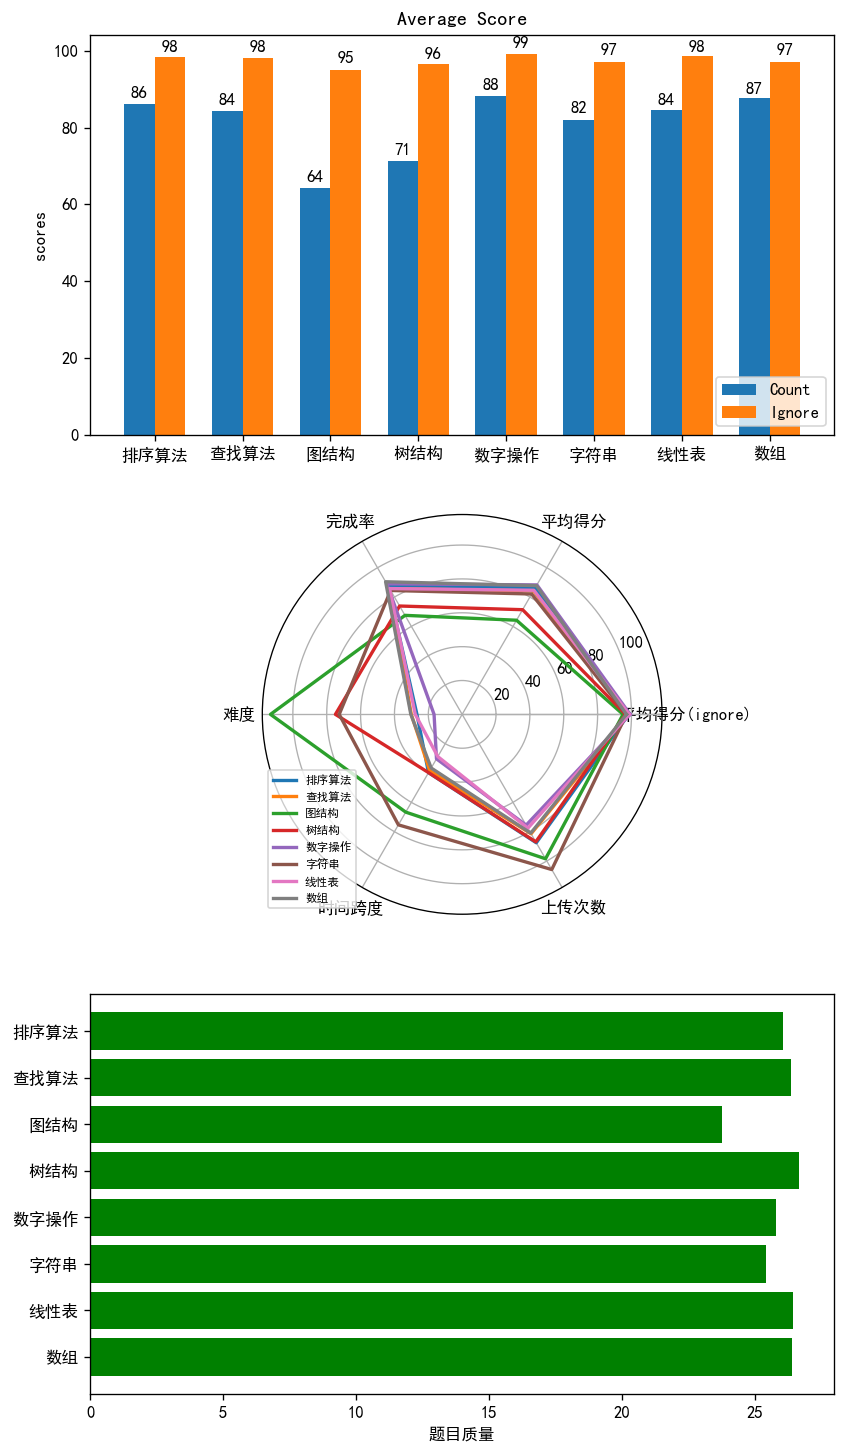

In [26]:
def autolabel(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def getTypeView():
    labels=type_dict.keys()
    x = np.arange(len(labels))
    width=0.35
    mp.figure(figsize=(8,15), dpi=120)
    mp.figure(1)
    #分组条形
    ax1=mp.subplot(311)
    ax1.set_title("Average Score")
    ax1.set_ylabel('scores')
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels)
    rect1=ax1.bar(x-width/2,typeAverageScoreCount,width,label='Count')
    rect2=ax1.bar(x+width/2,typeAverageScoreIg,width,label='Ignore')
    ax1.legend([rect1,rect2],['Count','Ignore'],loc='lower right')
    autolabel(rect1,ax1)
    autolabel(rect2,ax1)
    #雷达图
    ax2=mp.subplot(312, polar=True)
    labels=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数']
    kinds=list(type_dict.keys())
    global typeRadar
    result=pd.concat([typeRadar,typeRadar['平均得分(ignore)']],axis=1)
    centers=np.array(result.iloc[:,:])
    n=len(labels)
    angle=np.linspace(0,2*np.pi,n,endpoint=False)
    angle=np.concatenate((angle,[angle[0]]))
    pic=[]
    for i in range(len(kinds)):
        pic.append(ax2.plot(angle,centers[i],linewidth=2,label=kinds[i]))
    ax2.set_thetagrids(angle*180/np.pi,labels)
    ax2.legend(loc='lower left',fontsize='x-small')
    #题目质量水平条形图
    global typequality
    ax3=mp.subplot(313)
    ax3.barh(np.arange(8),typequality,color='g')
    ax3.set_yticks(np.arange(8))
    ax3.set_yticklabels(kinds)
    ax3.invert_yaxis()
    ax3.set_xlabel('题目质量')
    mp.show()
getTypeView()

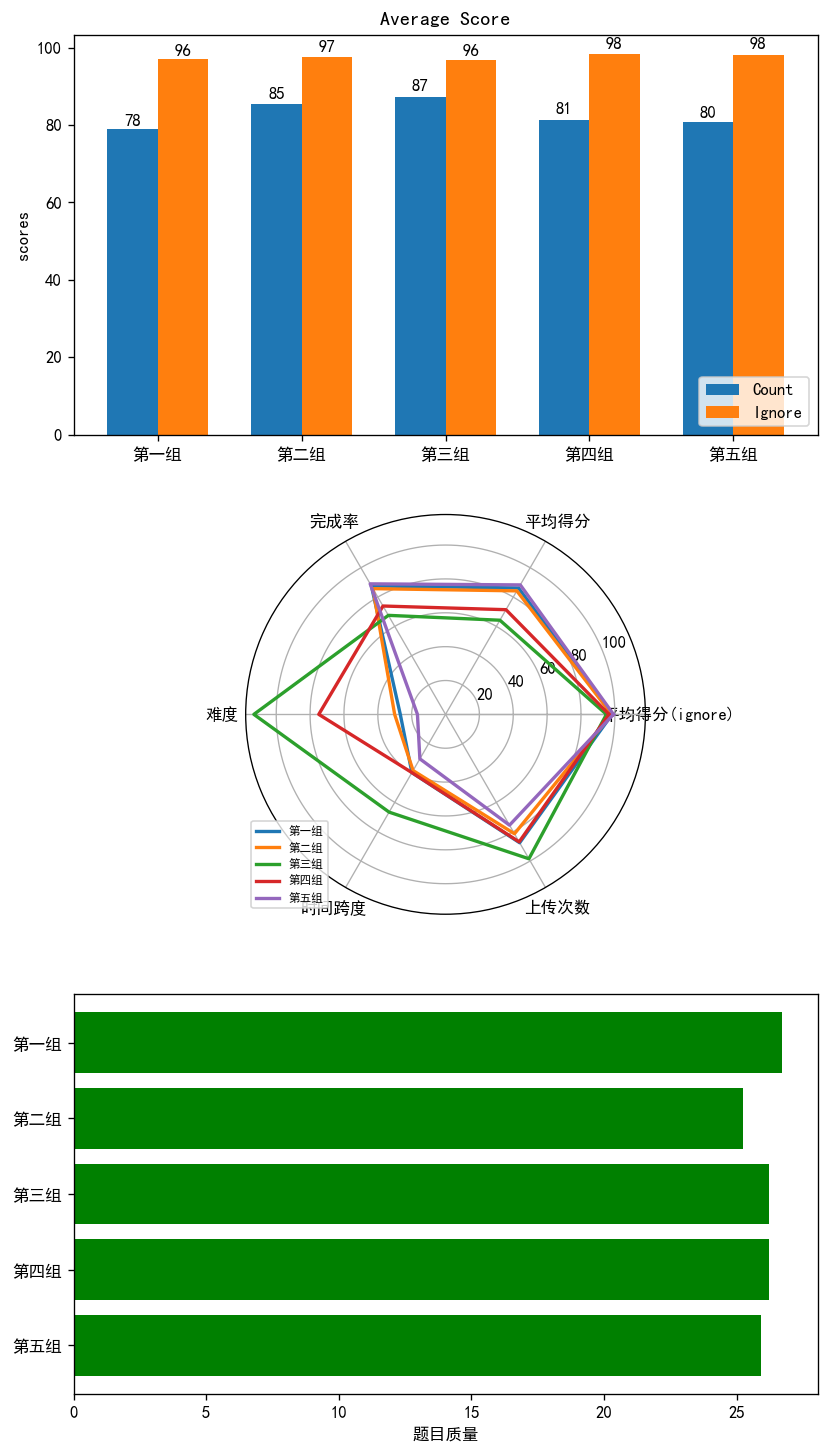

In [27]:
def getGroupView():
    labels=['第一组','第二组','第三组','第四组','第五组']
    x = np.arange(len(labels))
    width=0.35
    mp.figure(figsize=(8,15), dpi=120)
    mp.figure(1)
    #分组条形
    ax1=mp.subplot(311)
    ax1.set_title("Average Score")
    ax1.set_ylabel('scores')
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels)
    rect1=ax1.bar(x-width/2,groupAverageScoreCount,width,label='Count')
    rect2=ax1.bar(x+width/2,groupAverageScoreIg,width,label='Ignore')
    ax1.legend([rect1,rect2],['Count','Ignore'],loc='lower right')
    autolabel(rect1,ax1)
    autolabel(rect2,ax1)
    #雷达图
    ax2=mp.subplot(312, polar=True)
    kinds=labels
    labels=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数']
    global groupRadar
    result=pd.concat([groupRadar,groupRadar['平均得分(ignore)']],axis=1)
    centers=np.array(result.iloc[:,:])
    n=len(labels)
    angle=np.linspace(0,2*np.pi,n,endpoint=False)
    angle=np.concatenate((angle,[angle[0]]))
    pic=[]
    for i in range(len(kinds)):
        pic.append(ax2.plot(angle,centers[i],linewidth=2,label=kinds[i]))
    ax2.set_thetagrids(angle*180/np.pi,labels)
    ax2.legend(loc='lower left',fontsize='x-small')
    #题目质量水平条形图
    global groupquality
    ax3=mp.subplot(313)
    ax3.barh(np.arange(5),groupquality,color='g')
    ax3.set_yticks(np.arange(5))
    ax3.set_yticklabels(kinds)
    ax3.invert_yaxis()
    ax3.set_xlabel('题目质量')
    mp.show()
getGroupView()


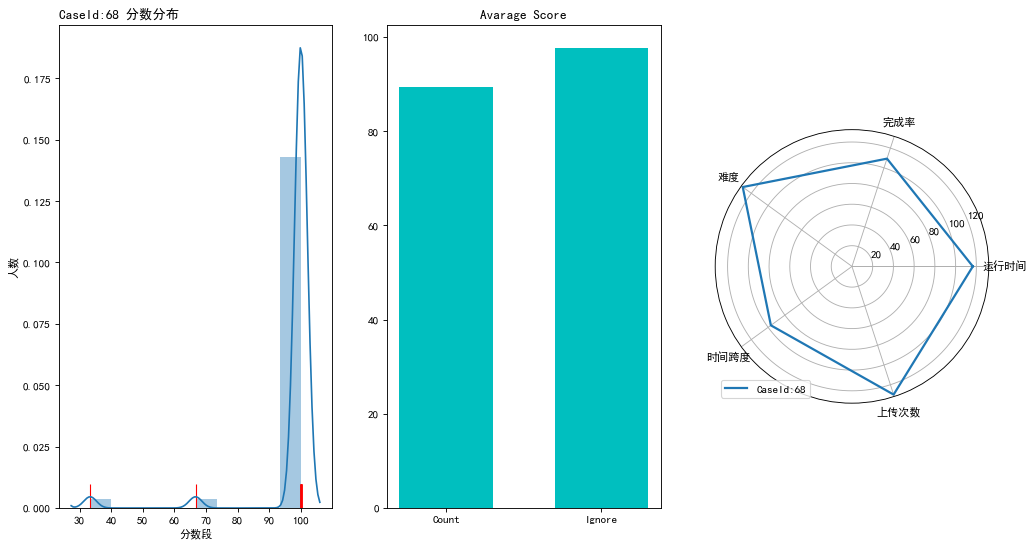

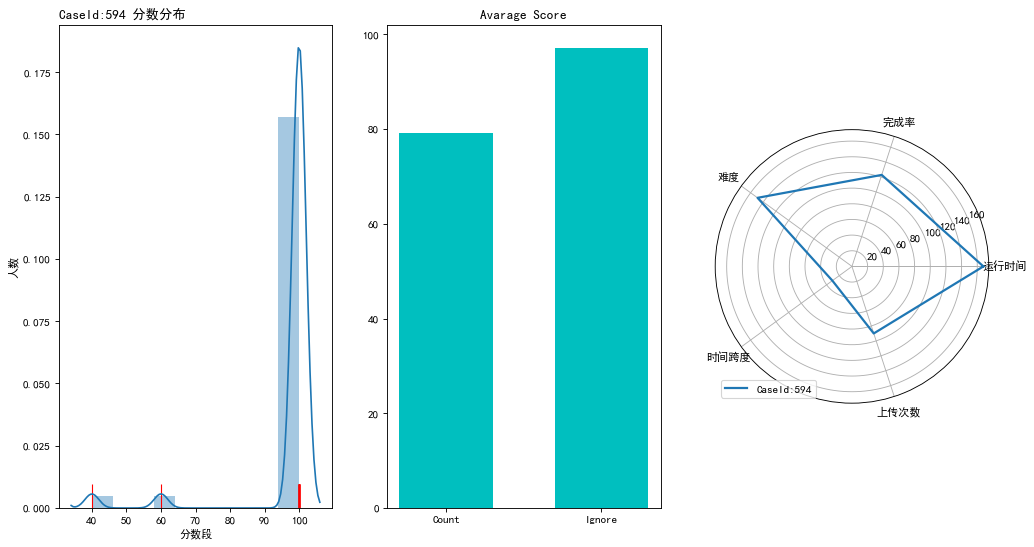

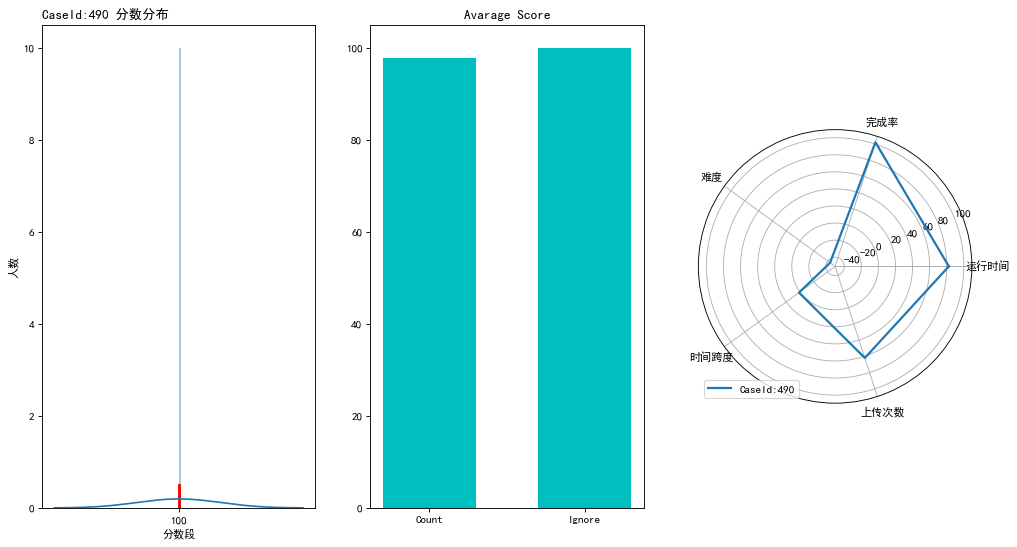

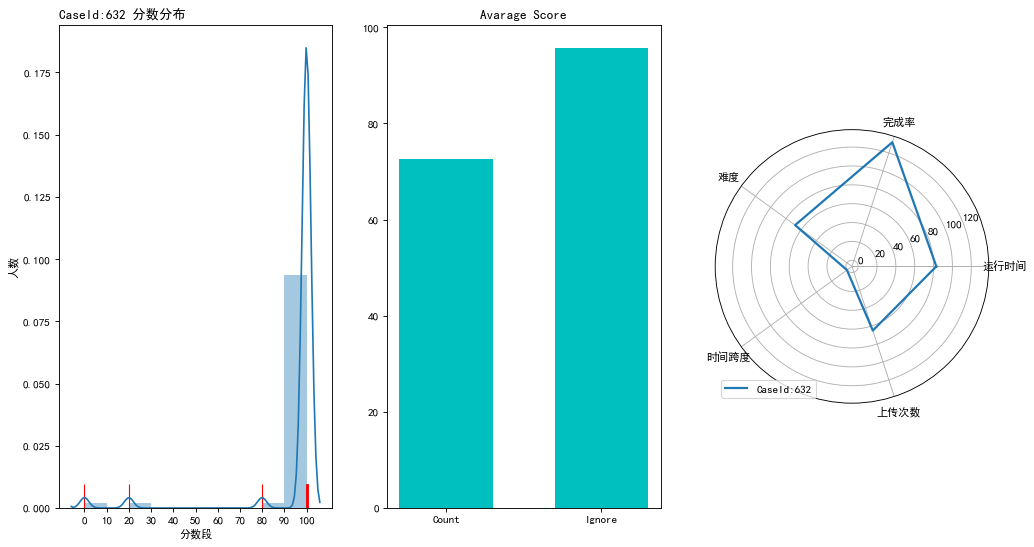

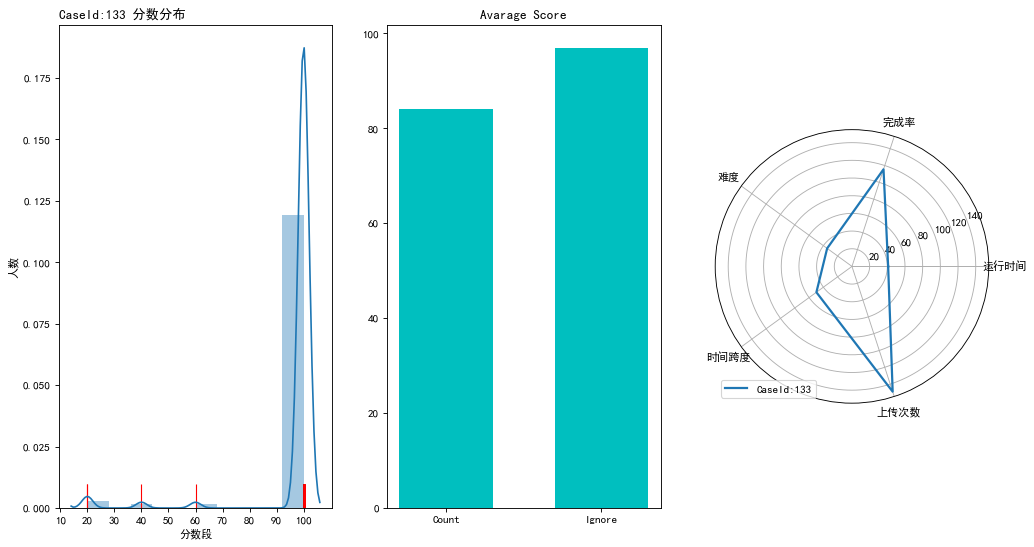

In [31]:
def getViewByCaseId(x):
    mp.figure(figsize=(15,8), dpi=80)
    mp.figure(1)
    #
    ax1=mp.subplot(131)
    label='CaseId:'+str(x)+' 分数分布'
    caseScore=pd.DataFrame(np.array(caseAllScores[x]).reshape(1,-1))
    bins = np.arange(0, 101, 10)
    ax1.set_title(label,loc='left')
    ax1.set_xticks(range(0,101,10))
    ax1.set_xlabel('分数段')
    ax1.set_ylabel('人数')
    sns.distplot(caseScore,bins=10,ax=ax1,rug=True,rug_kws = {'color' : 'r'},
            kde_kws = {'bw' : 2})
    #
    ax2=mp.subplot(132)
    group=["Count","Ignore"]
    mean=np.array([caseScoreCountUndo[x],caseScoreIgnoreUndo[x]])
    ax2.set_title('Avarage Score')
    mp.bar(group,mean,color='c',width=0.6,align='center')
    #雷达图
    ax3=mp.subplot(133, polar=True)
    labels=['运行时间','完成率','难度','时间跨度','上传次数']
    kinds=['CaseId:'+str(x)]
    CR=pd.DataFrame([[runtime[x]*100000,fr[x]*100,difficulty[x]*30,spanTime[x]/5,uploadSum[x]]]
    ,columns=['运行时间','完成率','难度','时间跨度','上传次数'])
    result=pd.concat([CR,CR['运行时间']],axis=1)
    centers=np.array(result.iloc[:,:])
    n=len(labels)
    angle=np.linspace(0,2*np.pi,n,endpoint=False)
    angle=np.concatenate((angle,[angle[0]]))
    pic=[]
    for i in range(len(kinds)):
        pic.append(ax3.plot(angle,centers[i],linewidth=2,label=kinds[i]))
    ax3.set_thetagrids(angle*180/np.pi,labels)
    ax3.legend(loc='lower left')
    mp.show()
for i in random.sample(range(882),5):
    getViewByCaseId(i)

# 附录也很精彩模块的一些可视化结果

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
user_info=pd.read_csv('user_info.csv')
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}


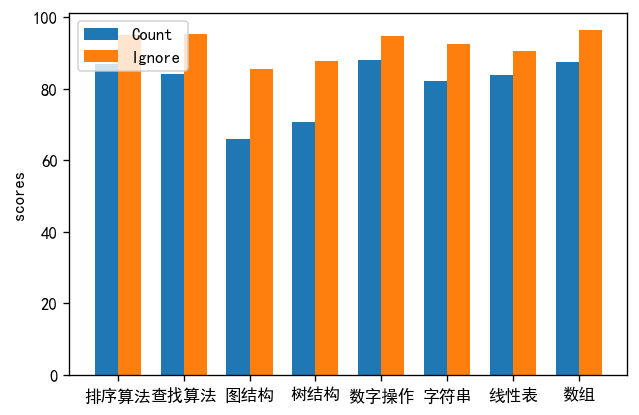

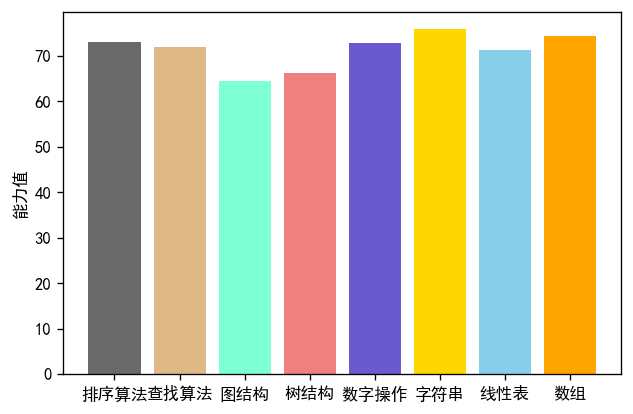

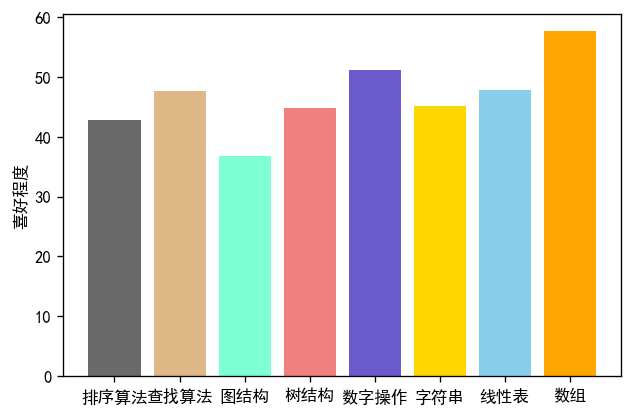

In [2]:
labels = list(type_dict.keys())
color=['dimgray','burlywood','aquamarine','lightcoral','slateblue','gold','skyblue','orange']
x = np.arange(len(labels))
width = 0.35
def scorebar():
    xc=[np.mean(user_info['avgScoreOfType0'].values),np.mean(user_info['avgScoreOfType1'].values),np.mean(user_info['avgScoreOfType2'].values),
        np.mean(user_info['avgScoreOfType3'].values),np.mean(user_info['avgScoreOfType4'].values),np.mean(user_info['avgScoreOfType5'].values),
        np.mean(user_info['avgScoreOfType6'].values),np.mean(user_info['avgScoreOfType7'].values)]
    xi=[np.mean(user_info['avgScoreIgnoreUndoOfType0'].values),np.mean(user_info['avgScoreIgnoreUndoOfType1'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType2'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType3'].values),np.mean(user_info['avgScoreIgnoreUndoOfType4'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType5'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType6'].values),np.mean(user_info['avgScoreIgnoreUndoOfType7'].values)]
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
    rect1 = ax.bar(x - width / 2, xc, width, label='Count')
    rect2 = ax.bar(x + width / 2, xi, width, label='Ignore')
    ax.set_ylabel('scores')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.legend([rect1, rect2], ['Count', 'Ignore'], loc='upper left')
def abilitybar():
    xc=[np.mean(user_info['userAbilityOfType0'].values),np.mean(user_info['userAbilityOfType1'].values),np.mean(user_info['userAbilityOfType2'].values),
        np.mean(user_info['userAbilityOfType3'].values),np.mean(user_info['userAbilityOfType4'].values),np.mean(user_info['userAbilityOfType5'].values),
        np.mean(user_info['userAbilityOfType6'].values),np.mean(user_info['userAbilityOfType7'].values)]
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
    ax.bar(x, xc, color=color)
    ax.set_ylabel('能力值')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
def likebar():
    xc=[np.mean(user_info['likeDegreeOfType0'].values),np.mean(user_info['likeDegreeOfType1'].values),np.mean(user_info['likeDegreeOfType2'].values),
        np.mean(user_info['likeDegreeOfType3'].values),np.mean(user_info['likeDegreeOfType4'].values),np.mean(user_info['likeDegreeOfType5'].values),
        np.mean(user_info['likeDegreeOfType6'].values),np.mean(user_info['likeDegreeOfType7'].values)]
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    plt.style.use('ggplot')
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
    ax.bar(x, xc,color=color)
    ax.set_ylabel('喜好程度')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
scorebar()
abilitybar()
likebar()

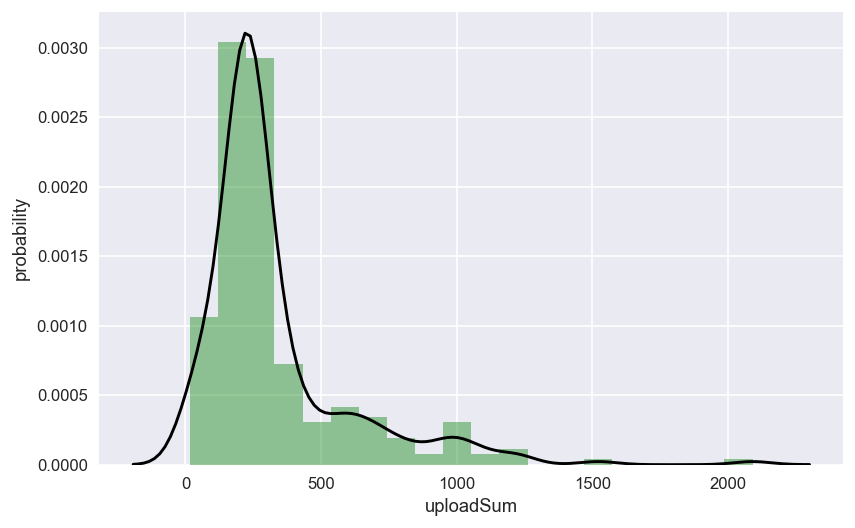

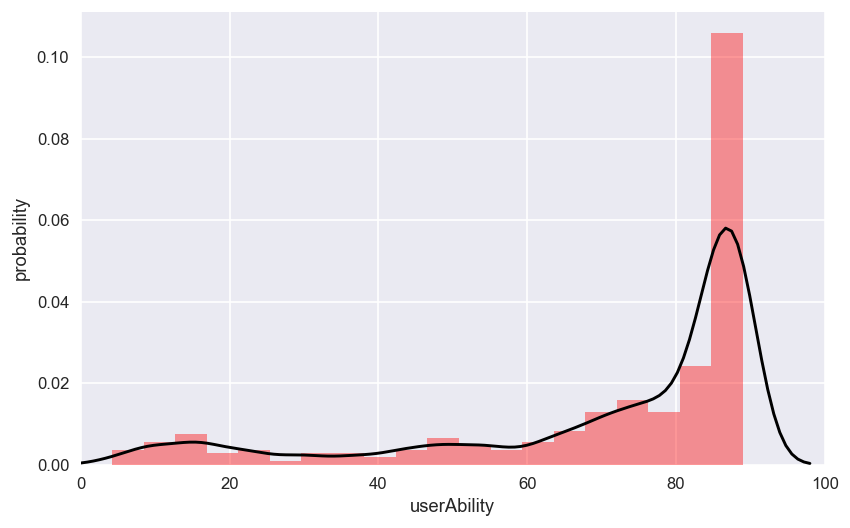

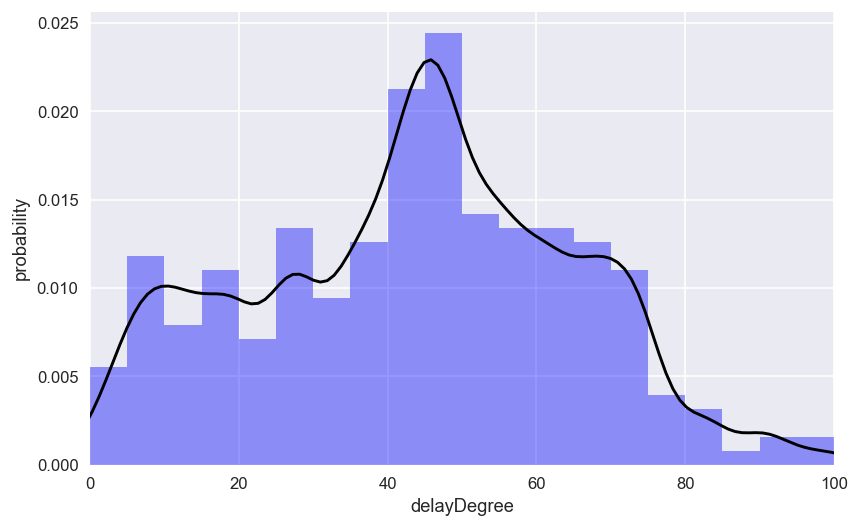

In [3]:
def getUploadhist():
    plt.style.use('seaborn')
    data=user_info['uploadSum']
    fig,ax=plt.subplots(figsize=(8,5),dpi=120)
    ax.set_xlabel('uploadSum')
    ax.set_ylabel('probability')
    sns.distplot(data,bins=20,color="g",
                 kde_kws={"color": "k", "bw": 70})
def getAbilityhist():
    plt.style.use('seaborn')
    data=user_info['userAbility']
    fig,ax=plt.subplots(figsize=(8,5),dpi=120)
    ax.set_xlim((0,100))
    ax.set_xlabel('userAbility')
    ax.set_ylabel('probability')
    sns.distplot(data,bins=20,color="r",
                 kde_kws={"color": "k", "bw": 3})
def getDelayhist():
    plt.style.use('seaborn')
    data=user_info['delayDegree']
    fig,ax=plt.subplots(figsize=(8,5),dpi=120)
    ax.set_xlim((0,100))
    ax.set_xlabel('delayDegree')
    ax.set_ylabel('probability')
    sns.distplot(data,bins=20,color="b",
                 kde_kws={"color": "k", "bw": 3})
getUploadhist()
getAbilityhist()
getDelayhist()

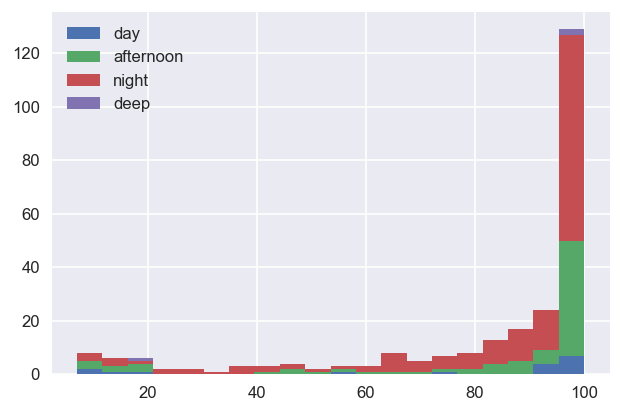

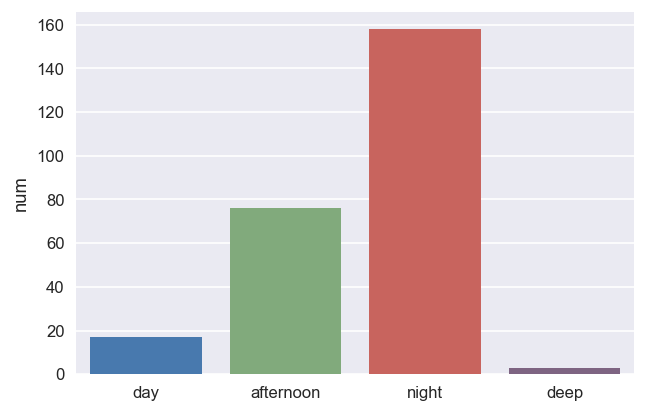

In [4]:
def getTimeTypeandScoreView():
    plt.style.use('seaborn')
    day_stu=user_info[user_info['timeType']==0]['avgScore'].values
    aft_stu=user_info[user_info['timeType']==1]['avgScore'].values
    night_stu=user_info[user_info['timeType']==2]['avgScore'].values
    deep_stu=user_info[user_info['timeType']==3]['avgScore'].values
    y=[day_stu.shape[0],aft_stu.shape[0],night_stu.shape[0],deep_stu.shape[0]]
    stu=np.array([day_stu,aft_stu,night_stu,deep_stu])
    data=pd.DataFrame({'timeType':user_info['timeType'],'score':user_info['avgScore'],'score_i':user_info['avgScoreIgnoreUndo']})
    data=data.corr(method='kendall')
    labels=['day','afternoon','night','deep']
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    ax.hist(stu, 20,  histtype='bar', stacked=True,label=labels)
    ax.legend(loc='upper left')
    plt.show()
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    ax.set_ylabel('num')
    ax.set_ylabel('num')
    sns.barplot(x=labels, y=y, palette=sns.xkcd_palette(["windows blue","faded green","pale red","dusty purple"]))
    plt.show()
getTimeTypeandScoreView()

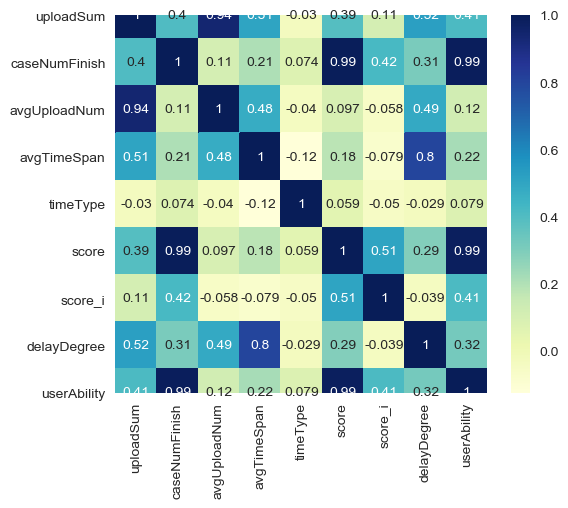

C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\60960\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


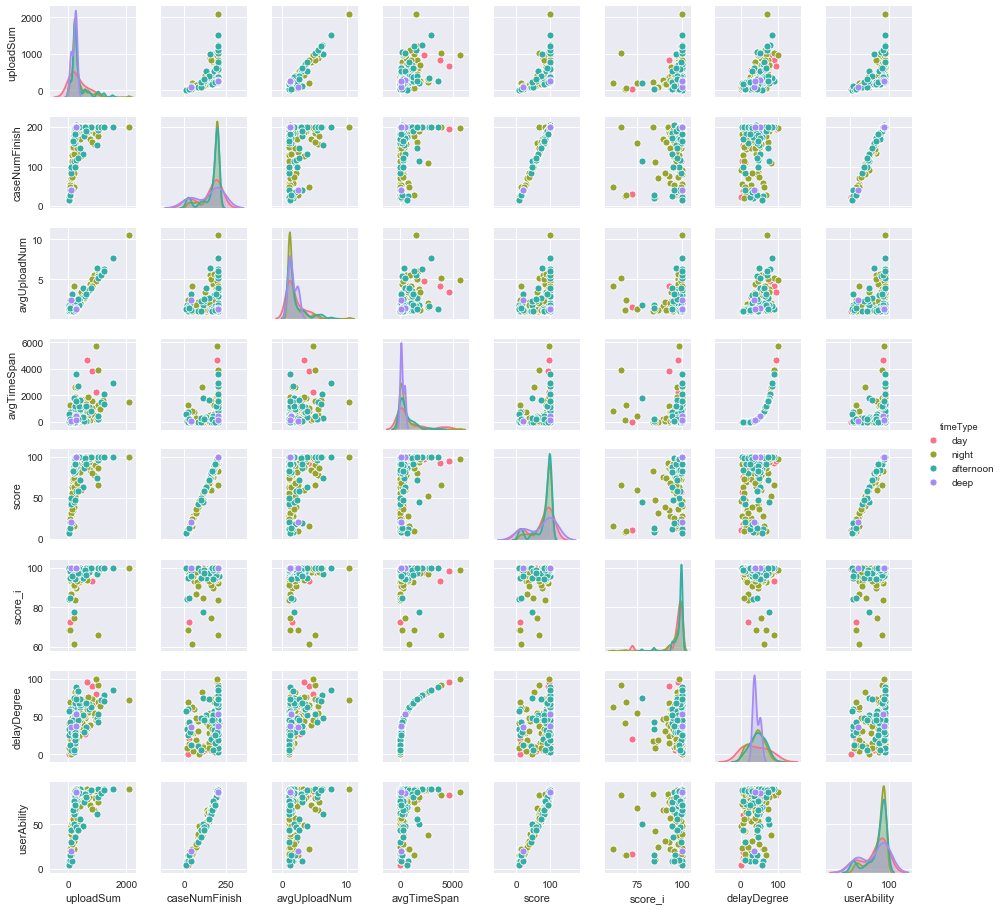

In [5]:
data=pd.DataFrame({'uploadSum':user_info['uploadSum'],'caseNumFinish':user_info['caseNumFinish'],'avgUploadNum':user_info['avgUploadNum'],
                   'avgTimeSpan':user_info['avgTimeSpan'],'timeType':user_info['timeType'],'score':user_info['avgScore'],
                   'score_i':user_info['avgScoreIgnoreUndo'],'delayDegree':user_info['delayDegree'],'userAbility':user_info['userAbility']})
cor=data.corr()
fig=plt.figure(figsize=(6,5),dpi=100)
ax=plt.subplot(111)
sns.heatmap(cor,annot=True,cmap='YlGnBu')
plt.show()
timeType=[]
for i in data['timeType']:
    if i==0:
        timeType.append('day')
    elif i==1:
        timeType.append('afternoon')
    elif i==2:
        timeType.append('night')
    else:
        timeType.append('deep')
data['timeType']=timeType
sns.pairplot(data, hue="timeType",palette="husl",height=1.6)
plt.show()

In [6]:
# cases_analysis_result=pd.read_csv('E:\\0学习资料\\A软件工程\\数据科学大作业\\data-science\\cases_analysis_final.csv')
# data=pd.DataFrame({'finish_rate':cases_analysis_result['finishRate'],'average_point_i':cases_analysis_result['scoreIgnoreUndo'],
#                    'average_point':cases_analysis_result['scoreCountUndo'],'upload_num':cases_analysis_result['uploadAvg'],
#                   'time_span':cases_analysis_result['timeSpan'],'runtime':cases_analysis_result['avgRunTime'],
#                    'difficulty':cases_analysis_result['difficultDegree']},index=[i for i in range(882)] )


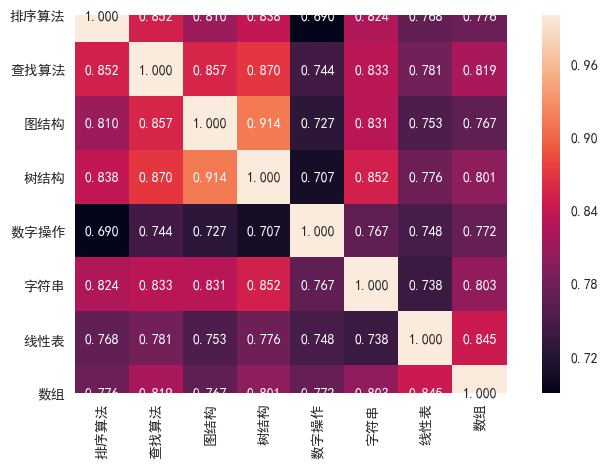

In [7]:
data=pd.DataFrame({'排序算法':user_info['avgScoreOfType0'],'查找算法':user_info['avgScoreOfType1'],'图结构':user_info['avgScoreOfType2'],
        '树结构':user_info['avgScoreOfType3'],'数字操作':user_info['avgScoreOfType4'],'字符串':user_info['avgScoreOfType5'],
        '线性表':user_info['avgScoreOfType6'],'数组':user_info['avgScoreOfType7']})
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
corrmat=data.corr(method='spearman')
plt.figure(figsize=(9,5),dpi=100)
sns.heatmap(corrmat, annot=True, fmt='.3f', square=True);
plt.show()

# 下面是基于`streamlit`搭建的数据科学web程序

In [9]:
import streamlit as st
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
user_info=pd.read_csv('user_info.csv')
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
sidebar = st.sidebar
type = sidebar.selectbox("选择功能", ('查看报告', '获取学习路线&推荐题目', '寻找编程搭档'))
value=sidebar.text_input(label='输入学生id')
if value!='' and type=='查看报告':
    st.markdown('# 学生个人编程报告')
    st.markdown('---')
    st.markdown('### 1.编程时间分布分析')
    st.markdown('---')
    id = int(value)
    data = user_info[user_info['id'] == id].iloc[:, 2:26]
    labels = ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00',
              '13:00', '14:00', '15:00', '16:00', '17:00'
        , '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
    fig=plt.figure(figsize=(12,7))
    ax=plt.subplot(111)
    rate = user_info[user_info['id'] == id].iloc[:, 26:50]
    st.markdown(' ')
    st.markdown(' ')
    st.write('**滑动查看各时间段提交比例**')
    time = st.slider('请选择一个时间段', 0, 23, 0, 1)
    st.write('该学生在', time, ':00 - ', time + 1, ':00的提交比例为', round(rate.values[0][time],4) * 100, '%')
    st.write('**分布图及做题时间类型占比**')
    st.markdown('##### 做题时间类型分为4种')
    st.table(pd.DataFrame({' day ':['上午型'],'afternoon':['下午型'],'night':['晚上型'],'deep':['深夜型']}))
    plt.style.use('seaborn')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel('time')
    ax.set_ylabel('upload_num')
    ax.bar(labels, data.values[0], width=1.0, color='purple')
    ax.plot(labels, data.values[0])
    st.pyplot()
    data = user_info[user_info['id'] == id].loc[:, 'dayRate':'deepRate']
    sizes = data.values[0]
    labels = ['morning', 'afternoon', 'night', 'deep']
    explode = (0.1, 0, 0, 0)
    ax = plt.subplot(111)
    ax.pie(sizes, explode=explode, labels=labels,
              shadow=True, startangle=90, wedgeprops={'width': 0.4})
    ax.axis('equal')
    ax.legend(loc='center right', bbox_to_anchor=(1, 0, 0.05, 1))
    st.pyplot()
    if user_info[user_info['id']== id]['timeType'].values[0]==0:
        timeType='上午型'
    elif user_info[user_info['id']== id]['timeType'].values[0]==1:
        timeType='下午型'
    elif user_info[user_info['id']== id]['timeType'].values[0]==2:
        timeType='晚上型'
    else :timeType='深夜型'
    st.write('*可以看出这是一位`'+timeType+"`选手*")
    timespan=user_info[user_info['id'] == id]['avgTimeSpan'].values[0]
    delaydegree=user_info[user_info['id'] == id]['delayDegree']
    st.markdown('**拖延症病情情况**')
    st.markdown('做题平均时间跨度为`'+str(int(timespan))+'`分钟')
    st.write('拖延症指数为`'+str(int(delaydegree))+'`')
    st.markdown('---')
    st.markdown('### 2.编程喜好分析')
    st.markdown('---')
    st.markdown(' ')
    st.markdown(' ')
    labels = list(type_dict.keys())
    color=['dimgray','burlywood','aquamarine','lightcoral','slateblue','gold','skyblue','orange']
    ax=plt.subplot(111)
    like = user_info[user_info['id'] == id].loc[:,
              ['likeDegreeOfType0', 'likeDegreeOfType1', 'likeDegreeOfType2', 'likeDegreeOfType3',
               'likeDegreeOfType4', 'likeDegreeOfType5', 'likeDegreeOfType6', 'likeDegreeOfType7']]
    plt.style.use('ggplot')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
    st.markdown('**各类型题目喜好程度**')
    ax.barh(np.arange(8), like.values[0], color=color)
    ax.set_yticks(np.arange(8))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel('喜好程度')
    st.pyplot()
    l=like.values[0].tolist()
    maxlike=l.index(max(l))
    st.markdown('*最喜欢的类型是`'+labels[maxlike]+'`类型*')
    minlike = l.index(min(l))
    st.markdown('*最讨厌的类型是`' + labels[minlike] + '`类型*')
    st.markdown('---')
    st.markdown('### 3.编程能力')
    st.markdown('---')
    st.markdown('**各类型完成率**')
    data = user_info[user_info['id'] == id].loc[:,
           ['finishRateOfType0', 'finishRateOfType1', 'finishRateOfType2', 'finishRateOfType3',
            'finishRateOfType4', 'finishRateOfType5', 'finishRateOfType6', 'finishRateOfType7']]
    ax = plt.subplot(111)
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(labels)
    ax.bar(np.arange(8), data.values[0], color=color)
    st.pyplot()
    st.markdown('**各类型平均分**')
    st.write('Count代表考虑没做的题目，Ignore则代表忽略')
    data = user_info[user_info['id'] == id].loc[:,
           ['avgScoreOfType0', 'avgScoreOfType1', 'avgScoreOfType2', 'avgScoreOfType3',
            'avgScoreOfType4', 'avgScoreOfType5', 'avgScoreOfType6', 'avgScoreOfType7']]
    datai= user_info[user_info['id'] == id].loc[:,
           ['avgScoreIgnoreUndoOfType0', 'avgScoreIgnoreUndoOfType1', 'avgScoreIgnoreUndoOfType2', 'avgScoreIgnoreUndoOfType3',
            'avgScoreIgnoreUndoOfType4', 'avgScoreIgnoreUndoOfType5', 'avgScoreIgnoreUndoOfType6', 'avgScoreIgnoreUndoOfType7']]
    ability=user_info[user_info['id'] == id].loc[:,
           ['userAbilityOfType0', 'userAbilityOfType1', 'userAbilityOfType2', 'userAbilityOfType3',
            'userAbilityOfType4', 'userAbilityOfType5', 'userAbilityOfType6', 'userAbilityOfType7']]
    l=ability.values[0].tolist()
    maxl=l.index(max(l))
    minl=l.index(min(l))
    x = np.arange(len(labels))
    width = 0.35
    ax1 = plt.subplot(111)
    ax1.set_title("Average Score")
    ax1.set_ylabel('scores')
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels)
    rect1 = ax1.bar(x - width / 2, data.values[0], width, label='Count')
    rect2 = ax1.bar(x + width / 2, datai.values[0], width, label='Ignore')
    ax1.legend([rect1, rect2], ['Count', 'Ignore'], loc='lower right')
    st.pyplot()
    result = pd.concat([ability, ability['userAbilityOfType0']], axis=1)
    centers = np.array(result.iloc[:, :])
    n = len(labels)
    angle = np.linspace(0, 2 * np.pi, n, endpoint=False)
    angle = np.concatenate((angle, [angle[0]]))
    st.markdown('**编程能力图**')
    ax3 = plt.subplot(111, polar=True)
    ax3.plot(angle, centers[0], linewidth=2, color='cyan')
    ax3.set_thetagrids(angle * 180 / np.pi, labels)
    st.pyplot()
    st.markdown('`' + labels[maxl] + '`类型表现最好，`'+labels[minl]+'`类型还需加强')
    st.markdown('---')
def getCodeRoadForUser(userId):
    user_info=pd.read_csv('user_info.csv')
    abilities=[]
    for i in range(8):
        abilities.append(float(user_info[user_info['id']==userId]['userAbilityOfType'+str(i)]))
    abilities=np.array(abilities)
    return list(np.argsort(abilities))
caseIdsByType=np.load('caseIdByType.npy', allow_pickle=True)
def getRecommendCaseIdsUserLike(userId):
    user_info=pd.read_csv('user_info.csv')
    typeIds=[]
    typeIds1=list(np.argsort(-np.array([float(user_info[user_info['id']==userId]['userAbilityOfType'+str(i)]) for i in range(8)]))[:4])
    typeIds2=list(np.argsort(np.array([float(user_info[user_info['id']==userId]['likeDegreeOfType'+str(i)]) for i in range(8)]))[:4])
    for i in range(4):
        for j in range(i+1):
            typeIds.append(typeIds1[i])
            typeIds.append(typeIds2[i])
    recommendCaseIds=set()
    for i in range(25):
        recommendCaseIds.add(np.random.choice(caseIdsByType[np.random.choice(typeIds)]))
    return list(recommendCaseIds)

def getRecommendCaseIdsUserDislike(userId):
    user_info=pd.read_csv('user_info.csv')
    typeIds=[]
    typeIds1=np.argsort(np.array([float(user_info[user_info['id']==userId]['userAbilityOfType'+str(i)]) for i in range(8)]))[:4]
    typeIds2=np.argsort(-np.array([float(user_info[user_info['id']==userId]['likeDegreeOfType'+str(i)]) for i in range(8)]))[:4]
    for i in range(4):
        for j in range(i+1):
            typeIds.append(typeIds1[i])
            typeIds.append(typeIds2[i])
    recommendCaseIds=set()
    for i in range(25):
        recommendCaseIds.add(np.random.choice(caseIdsByType[np.random.choice(typeIds)]))
    return list(recommendCaseIds)
def geth(result):
    if len(result) % 5 == 0:
        h = 5
    elif len(result) % 4 == 0:
        h = 4
    elif len(result) % 3 == 0:
        h = 3
    elif len(result) % 2 == 0:
        h = 2
    else:
        h = 1
    return h
if value!='' and type=='获取学习路线&推荐题目':
    st.markdown('# 获取学习路线')
    st.markdown('---')
    st.markdown('**此路线为在对学生各类型题目进行客观准确评估后制定，学生可以按照返回的结果按优先级从高到低强化编程练习**')
    labels = list(type_dict.keys())
    result=getCodeRoadForUser(int(value))
    fig = plt.figure(figsize=(12, 7))
    ax = plt.subplot(111)
    colors = ['dimgray', 'burlywood', 'aquamarine', 'lightcoral', 'slateblue', 'gold', 'skyblue', 'orange']
    sizes=np.array([2000,2500,1500,750,500,1000,1200,1800])
    np.random.shuffle(sizes)
    x=np.arange(8)
    plt.style.use('seaborn-dark')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.set_xticks([])  # 去掉x轴
    ax.set_yticks([])  # 去掉y轴
    ax.plot(x,result,color='k')
    ax.scatter(x,result,c=colors,s=sizes)
    for x, y in zip(x, result):
        ax.text(x, y + 1, labels[y], ha='center', va='bottom', fontsize=15)
    ax.text(0,result[0]-1,'起点', ha='center', va='bottom', fontsize=15)
    ax.text(7, result[-1] - 1, '终点', ha='center', va='bottom', fontsize=15)
    st.pyplot()
    st.markdown('---')
    st.markdown('# 获取推荐题目编号')
    st.markdown('---')
    st.markdown('**自动推荐代码模块将从两个角度给学生推荐题目编号，分别是"心动模式"和"考验模式"**')
    st.markdown('"心动模式"，即给学生优先推荐他所喜欢或擅长的题型的题目')
    st.markdown('"考验模式"，即给学生优先推荐他所不擅长或不喜欢的题目类型的题目')
    mode=st.radio('选择一种模式',('心动模式','考验模式'))
    st.write('题目id列表')
    if mode=='心动模式':
        result=getRecommendCaseIdsUserLike(int(value))
        h=geth(result)
        result=np.array(result).reshape(h,-1)
        st.table(result)
    else:
        result = getRecommendCaseIdsUserLike(int(value))
        h = geth(result)
        result = np.array(result).reshape(h,-1)
        st.table(result)
if value!='' and type=='寻找编程搭档':
    st.markdown('# 获取编程搭档编号')
    st.markdown('---')
    st.markdown('**在寻找编程搭档时，我们将从4个角度出发；**')
    st.markdown('第一个角度是寻找编程时间分布与自己最接近的搭档,能增加一起学习的时间')
    st.markdown('第二个角度是寻找与自己在各类题目上分数分布最接近的同学，即各方面能力与自己最接近的人')
    st.markdown('第三个角度是寻找与自己在各类题目上分数分布差异最大的同学，这有利于大家优势互补')
    st.markdown('第四个角度是"一键寻找"与自己能力最接近的同学，这会综合各种因素，包括平均得分、编程时间等各种因素。')
    id=int(value)
    st.markdown('---')
    mode=st.radio('',('时间角度','能力相似角度','能力互补角度','综合角度'))
    user_partner=pd.read_csv('user_partner.csv')
    st.write('学生id列表')
    if mode=='时间角度':
        result=np.array(eval(user_partner[user_partner['id']==id]['time'].values[0])).reshape(1,-1)
        st.table(result)
    elif mode == '能力相似角度':
        result = np.array(eval(user_partner[user_partner['id'] == id]['scoreClose'].values[0])).reshape(1, -1)
        st.table(result)
    elif mode == '能力互补角度':
        result = np.array(eval(user_partner[user_partner['id'] == id]['scoreFar'].values[0])).reshape(1, -1)
        st.table(result)
    else:
        result = np.array(eval(user_partner[user_partner['id'] == id]['ability'].values[0])).reshape(1, -1)
        st.table(result)